## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
device

device(type='cpu')

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)


<h1> Download the pbmc dataset from scvi-tools</h1>

In [3]:
import scvi
adata = scvi.data.pbmc_dataset()
adata.var['alt_names']=adata.var_names
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

Global seed set to 0


INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'alt_names'
    uns: 'cell_types', 'pca', 'neighbors', 'umap'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
adata.obs['str_labels'].value_counts()

CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: str_labels, dtype: int64

In [5]:
adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
adata.var['alt_names'].loc['ENSG00000196154']='S100A4'
adata.var['alt_names'].loc['ENSG00000105369']='CD79A'
adata.var['alt_names'].loc['ENSG00000153563']='CD8A'
adata.var['alt_names'].loc['ENSG00000170458']='CD14'
adata.var['alt_names'].loc['ENSG00000131981']='LGALS3'
adata.var['alt_names'].loc['ENSG00000105374']='NKG7'
adata.var['alt_names'].loc['ENSG00000111796']='KLRB1'
adata.var['alt_names'].loc['ENSG00000179639']='FCER1A'
adata.var['alt_names'].loc['ENSG00000101439']='CST3'
adata.var['alt_names'].loc['ENSG00000163736']='PPBP'
adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
adata.var['alt_names'].loc['ENSG00000188404']='SELL'
adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

marker_genes_dict= {
    'B cells':['CD79A'],
    'CD4 T cells':['IL7R','CCR7'],
    'CD8 T cells':['CD8A','NKG7','KLRB1'],
    'CD14+ Monocytes':['CD14','LGALS3'],
    'Dendritic cells':['FCER1A','CST3'],
    'NK Cells':['NKG7','KLRB1']}


/Users/jonathankarin/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<h3> Filter out 'Megakaryocytes' because of the low amount of cells</h3>

In [6]:
adata= adata[adata.obs['str_labels'].isin(['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic Cells' ,'FCGR3A+ Monocytes', 'NK cells'])]

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [8]:
adata_scaled = adata.copy()
sc.pp.scale(adata_scaled)

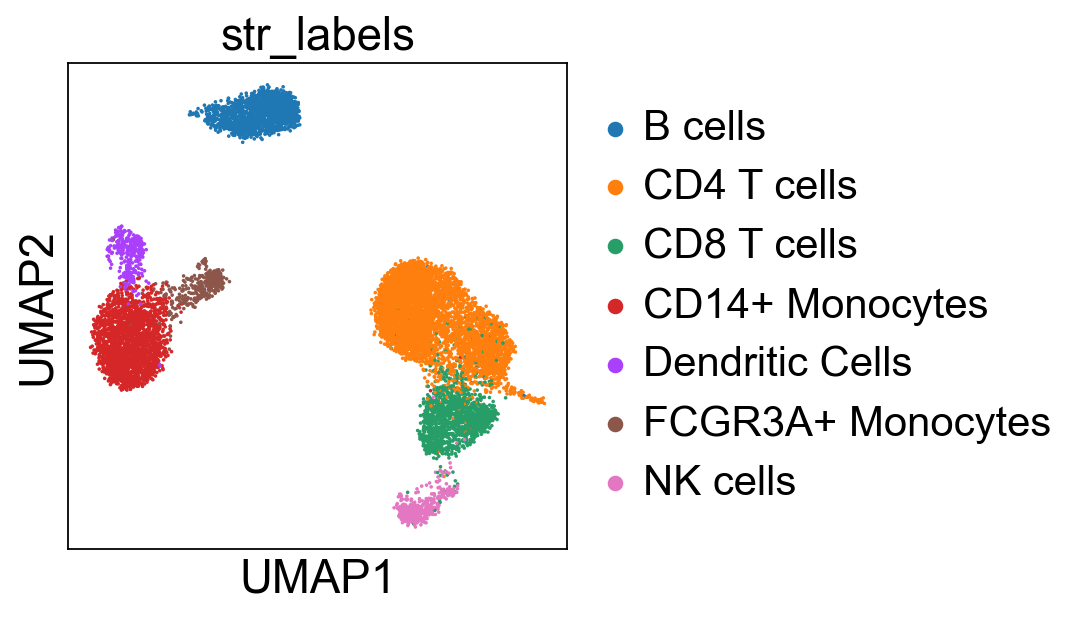

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='str_labels')

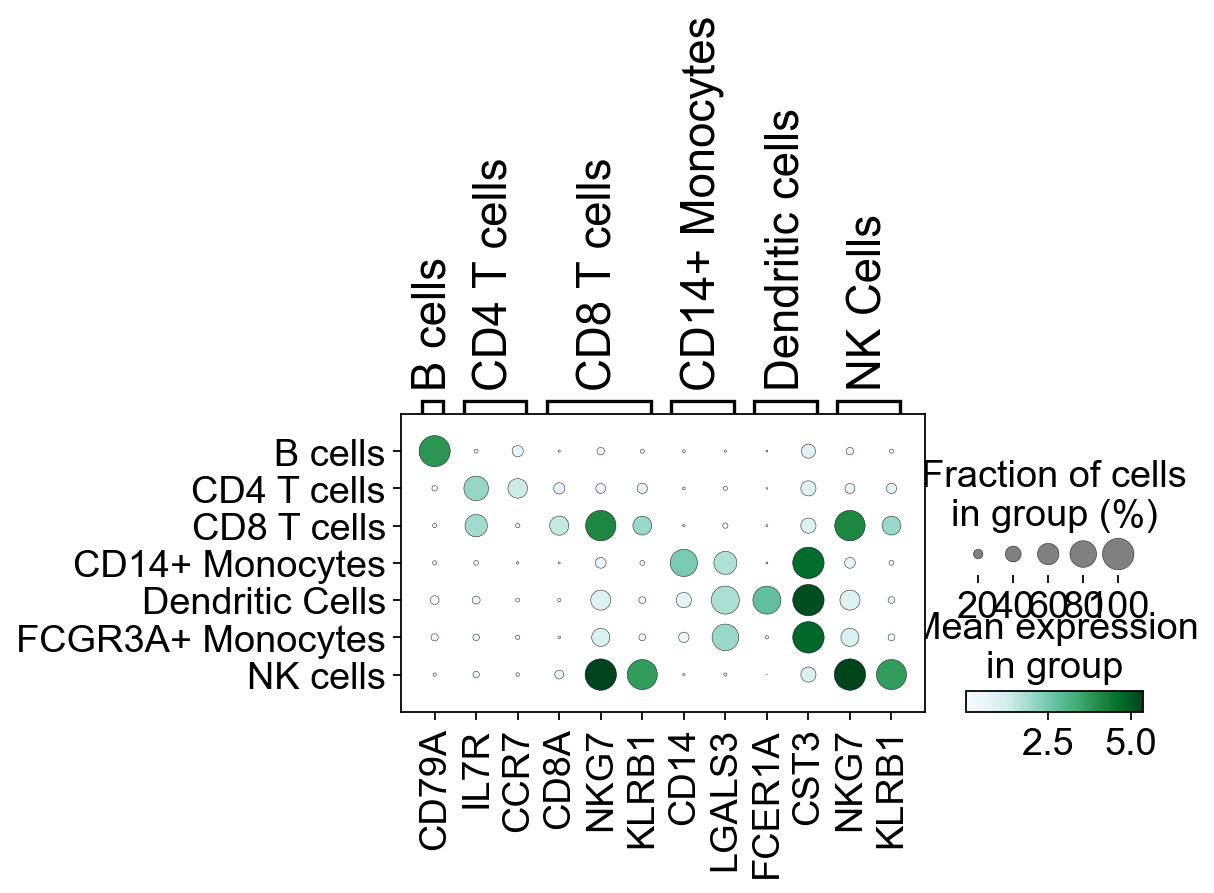

In [10]:
ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='str_labels', gene_symbols='alt_names', cmap='BuGn')


In [11]:
epoch_num=100
prob_list = models.follow_training_dyn_neural_net(adata, label_key='str_labels',iterNum=epoch_num, device=device)

[1,     2] loss: 0.389
[1,    12] loss: 1.927
[1,    22] loss: 1.870
[1,    32] loss: 1.790
[1,    42] loss: 1.708
[2,     2] loss: 0.322
[2,    12] loss: 1.543
[2,    22] loss: 1.398
[2,    32] loss: 1.257
[2,    42] loss: 1.108
[3,     2] loss: 0.194
[3,    12] loss: 0.903
[3,    22] loss: 0.788
[3,    32] loss: 0.689
[3,    42] loss: 0.614
[4,     2] loss: 0.110
[4,    12] loss: 0.516
[4,    22] loss: 0.465
[4,    32] loss: 0.410
[4,    42] loss: 0.368
[5,     2] loss: 0.066
[5,    12] loss: 0.316
[5,    22] loss: 0.309
[5,    32] loss: 0.288
[5,    42] loss: 0.251
[6,     2] loss: 0.051
[6,    12] loss: 0.235
[6,    22] loss: 0.214
[6,    32] loss: 0.201
[6,    42] loss: 0.214
[7,     2] loss: 0.043
[7,    12] loss: 0.182
[7,    22] loss: 0.172
[7,    32] loss: 0.152
[7,    42] loss: 0.172
[8,     2] loss: 0.033
[8,    12] loss: 0.151
[8,    22] loss: 0.144
[8,    32] loss: 0.143
[8,    42] loss: 0.156
[9,     2] loss: 0.033
[9,    12] loss: 0.129
[9,    22] loss: 0.135
[9,    32] 

[69,    42] loss: 0.021
[70,     2] loss: 0.002
[70,    12] loss: 0.016
[70,    22] loss: 0.011
[70,    32] loss: 0.017
[70,    42] loss: 0.015
[71,     2] loss: 0.005
[71,    12] loss: 0.019
[71,    22] loss: 0.020
[71,    32] loss: 0.016
[71,    42] loss: 0.013
[72,     2] loss: 0.004
[72,    12] loss: 0.015
[72,    22] loss: 0.012
[72,    32] loss: 0.012
[72,    42] loss: 0.016
[73,     2] loss: 0.005
[73,    12] loss: 0.020
[73,    22] loss: 0.018
[73,    32] loss: 0.018
[73,    42] loss: 0.016
[74,     2] loss: 0.002
[74,    12] loss: 0.017
[74,    22] loss: 0.017
[74,    32] loss: 0.019
[74,    42] loss: 0.017
[75,     2] loss: 0.004
[75,    12] loss: 0.012
[75,    22] loss: 0.016
[75,    32] loss: 0.018
[75,    42] loss: 0.016
[76,     2] loss: 0.002
[76,    12] loss: 0.017
[76,    22] loss: 0.021
[76,    32] loss: 0.020
[76,    42] loss: 0.017
[77,     2] loss: 0.002
[77,    12] loss: 0.017
[77,    22] loss: 0.012
[77,    32] loss: 0.015
[77,    42] loss: 0.014
[78,     2] loss

In [12]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

In [13]:
cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'str_labels',device,probability=0.1,percentile=25,epoch_num=epoch_num)

[1,     2] loss: 0.390
[1,    12] loss: 1.940
[1,    22] loss: 1.896
[1,    32] loss: 1.847
[1,    42] loss: 1.792
[2,     2] loss: 0.345
[2,    12] loss: 1.694
[2,    22] loss: 1.622
[2,    32] loss: 1.550
[2,    42] loss: 1.469
[3,     2] loss: 0.276
[3,    12] loss: 1.386
[3,    22] loss: 1.290
[3,    32] loss: 1.254
[3,    42] loss: 1.187
[4,     2] loss: 0.235
[4,    12] loss: 1.148
[4,    22] loss: 1.096
[4,    32] loss: 1.052
[4,    42] loss: 1.062
[5,     2] loss: 0.180
[5,    12] loss: 0.974
[5,    22] loss: 0.987
[5,    32] loss: 0.967
[5,    42] loss: 0.941
[6,     2] loss: 0.185
[6,    12] loss: 0.935
[6,    22] loss: 0.896
[6,    32] loss: 0.866
[6,    42] loss: 0.893
[7,     2] loss: 0.190
[7,    12] loss: 0.881
[7,    22] loss: 0.849
[7,    32] loss: 0.876
[7,    42] loss: 0.857
[8,     2] loss: 0.176
[8,    12] loss: 0.833
[8,    22] loss: 0.836
[8,    32] loss: 0.838
[8,    42] loss: 0.819
[9,     2] loss: 0.151
[9,    12] loss: 0.786
[9,    22] loss: 0.797
[9,    32] 

[69,    42] loss: 0.107
[70,     2] loss: 0.020
[70,    12] loss: 0.095
[70,    22] loss: 0.086
[70,    32] loss: 0.108
[70,    42] loss: 0.092
[71,     2] loss: 0.019
[71,    12] loss: 0.094
[71,    22] loss: 0.089
[71,    32] loss: 0.094
[71,    42] loss: 0.096
[72,     2] loss: 0.018
[72,    12] loss: 0.087
[72,    22] loss: 0.088
[72,    32] loss: 0.085
[72,    42] loss: 0.078
[73,     2] loss: 0.013
[73,    12] loss: 0.086
[73,    22] loss: 0.077
[73,    32] loss: 0.086
[73,    42] loss: 0.093
[74,     2] loss: 0.018
[74,    12] loss: 0.072
[74,    22] loss: 0.088
[74,    32] loss: 0.085
[74,    42] loss: 0.080
[75,     2] loss: 0.017
[75,    12] loss: 0.078
[75,    22] loss: 0.082
[75,    32] loss: 0.078
[75,    42] loss: 0.091
[76,     2] loss: 0.013
[76,    12] loss: 0.089
[76,    22] loss: 0.070
[76,    32] loss: 0.075
[76,    42] loss: 0.079
[77,     2] loss: 0.024
[77,    12] loss: 0.070
[77,    22] loss: 0.081
[77,    32] loss: 0.078
[77,    42] loss: 0.077
[78,     2] loss

In [14]:
adata.obs["var"] = all_var.detach().numpy()
adata.obs["conf"] = all_conf.detach().numpy()

In [15]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

In [16]:
adata.obs['CellType']=adata.obs['str_labels']

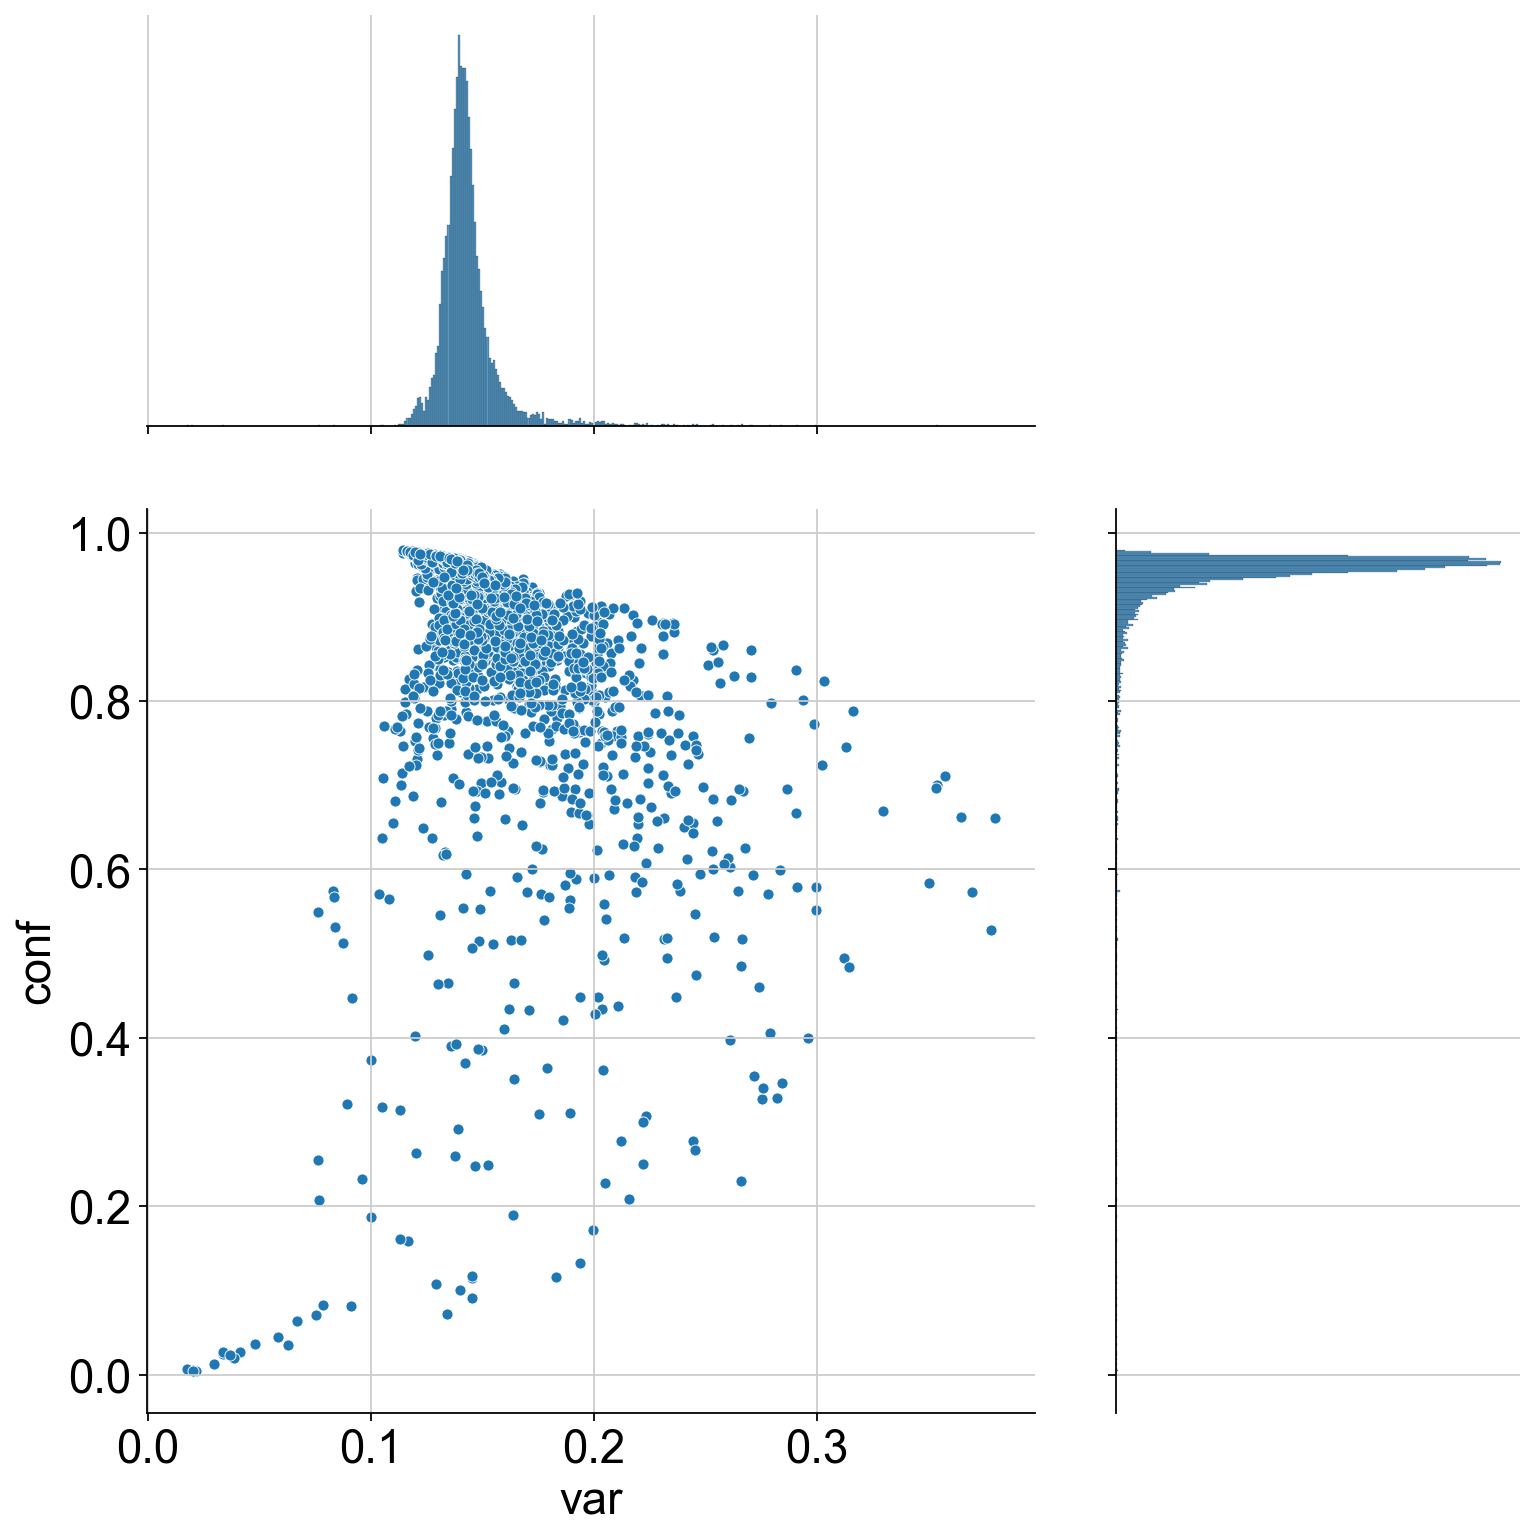

In [17]:

adata.obs['CellType']=adata.obs['str_labels']
sns.jointplot(data=adata.obs, x="var", y="conf",height=10,  s=25, ratio=2)
plt.ylabel('Confidence')
plt.xlabel('Variability')
plt.show()

In [18]:
cutoff_conf , cutoff_var

(0.2832595407962799, 0.2558937668800354)

In [19]:
adata.obs['conf_binaries'].value_counts()

True     11395
False       44
Name: conf_binaries, dtype: int64

In [20]:
sc.pp.pca(adata)#, color=['str_labels'])
sc.pp.neighbors(adata)#, color=['conf_binaries'])
sc.tl.umap(adata)#, color=['conf'])

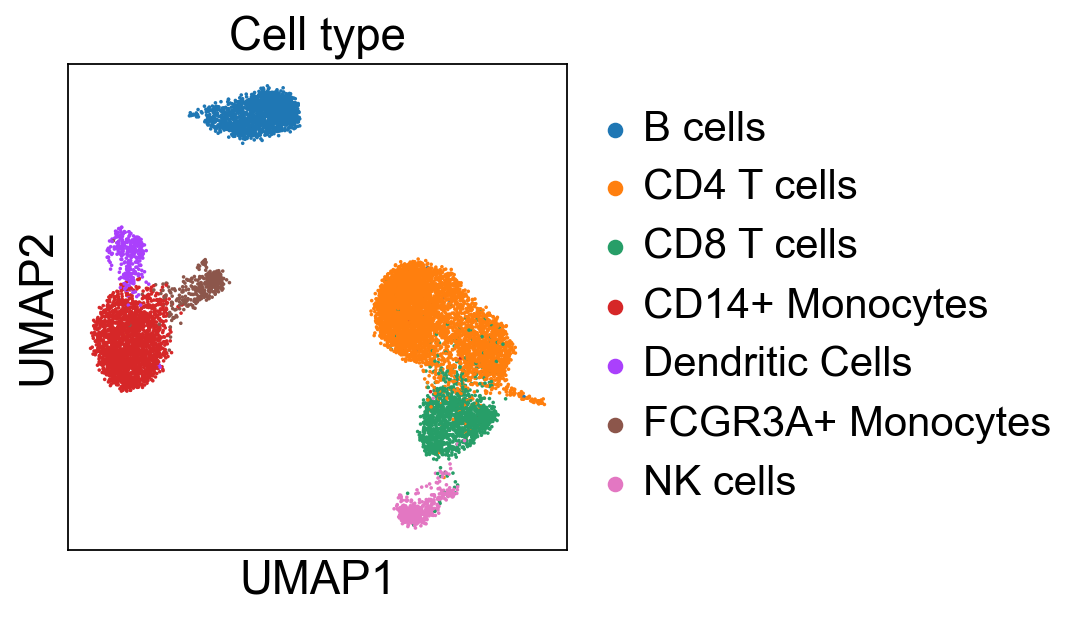

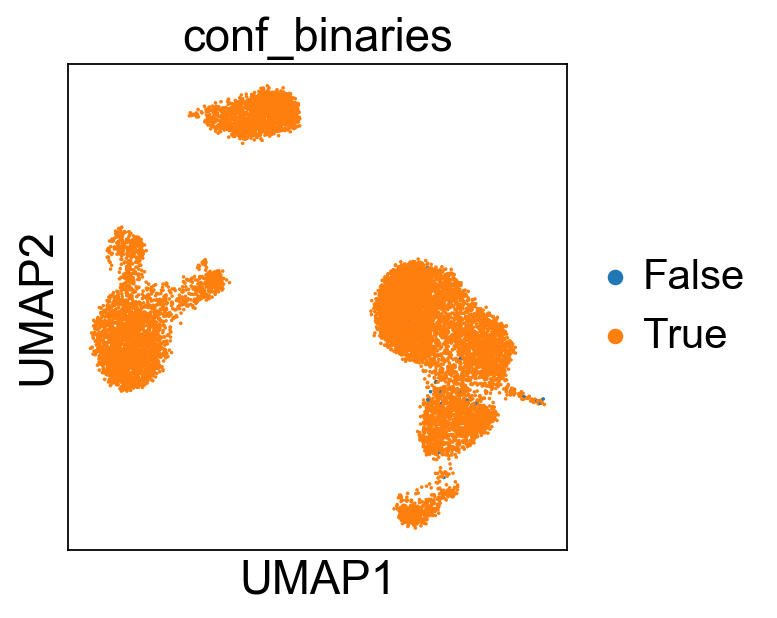

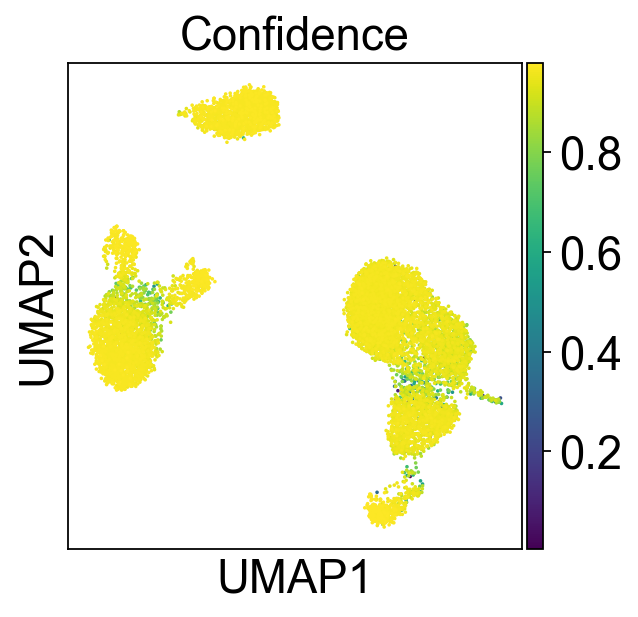

In [21]:
sc.pl.umap(adata, color=['str_labels'], title='Cell type')
sc.pl.umap(adata, color=['conf_binaries'])
sc.pl.umap(adata, color=['conf'], title='Confidence')

In [22]:
annotation_list =[]
for i in range(adata.n_obs):
    if (adata.obs['conf'][i] > cutoff_conf) | (adata.obs['var'][i] > cutoff_var):
        if (adata.obs['conf'][i] > 0.95) & (adata.obs['var'][i] < 0.15):
            annotation_list.append('Correctly annotated')
        else:
            annotation_list.append('Ambiguously annotated.')
    else:
            annotation_list.append('Erroneously annotated')

adata.obs['Annotation']=annotation_list
adata.obs[' ']=annotation_list


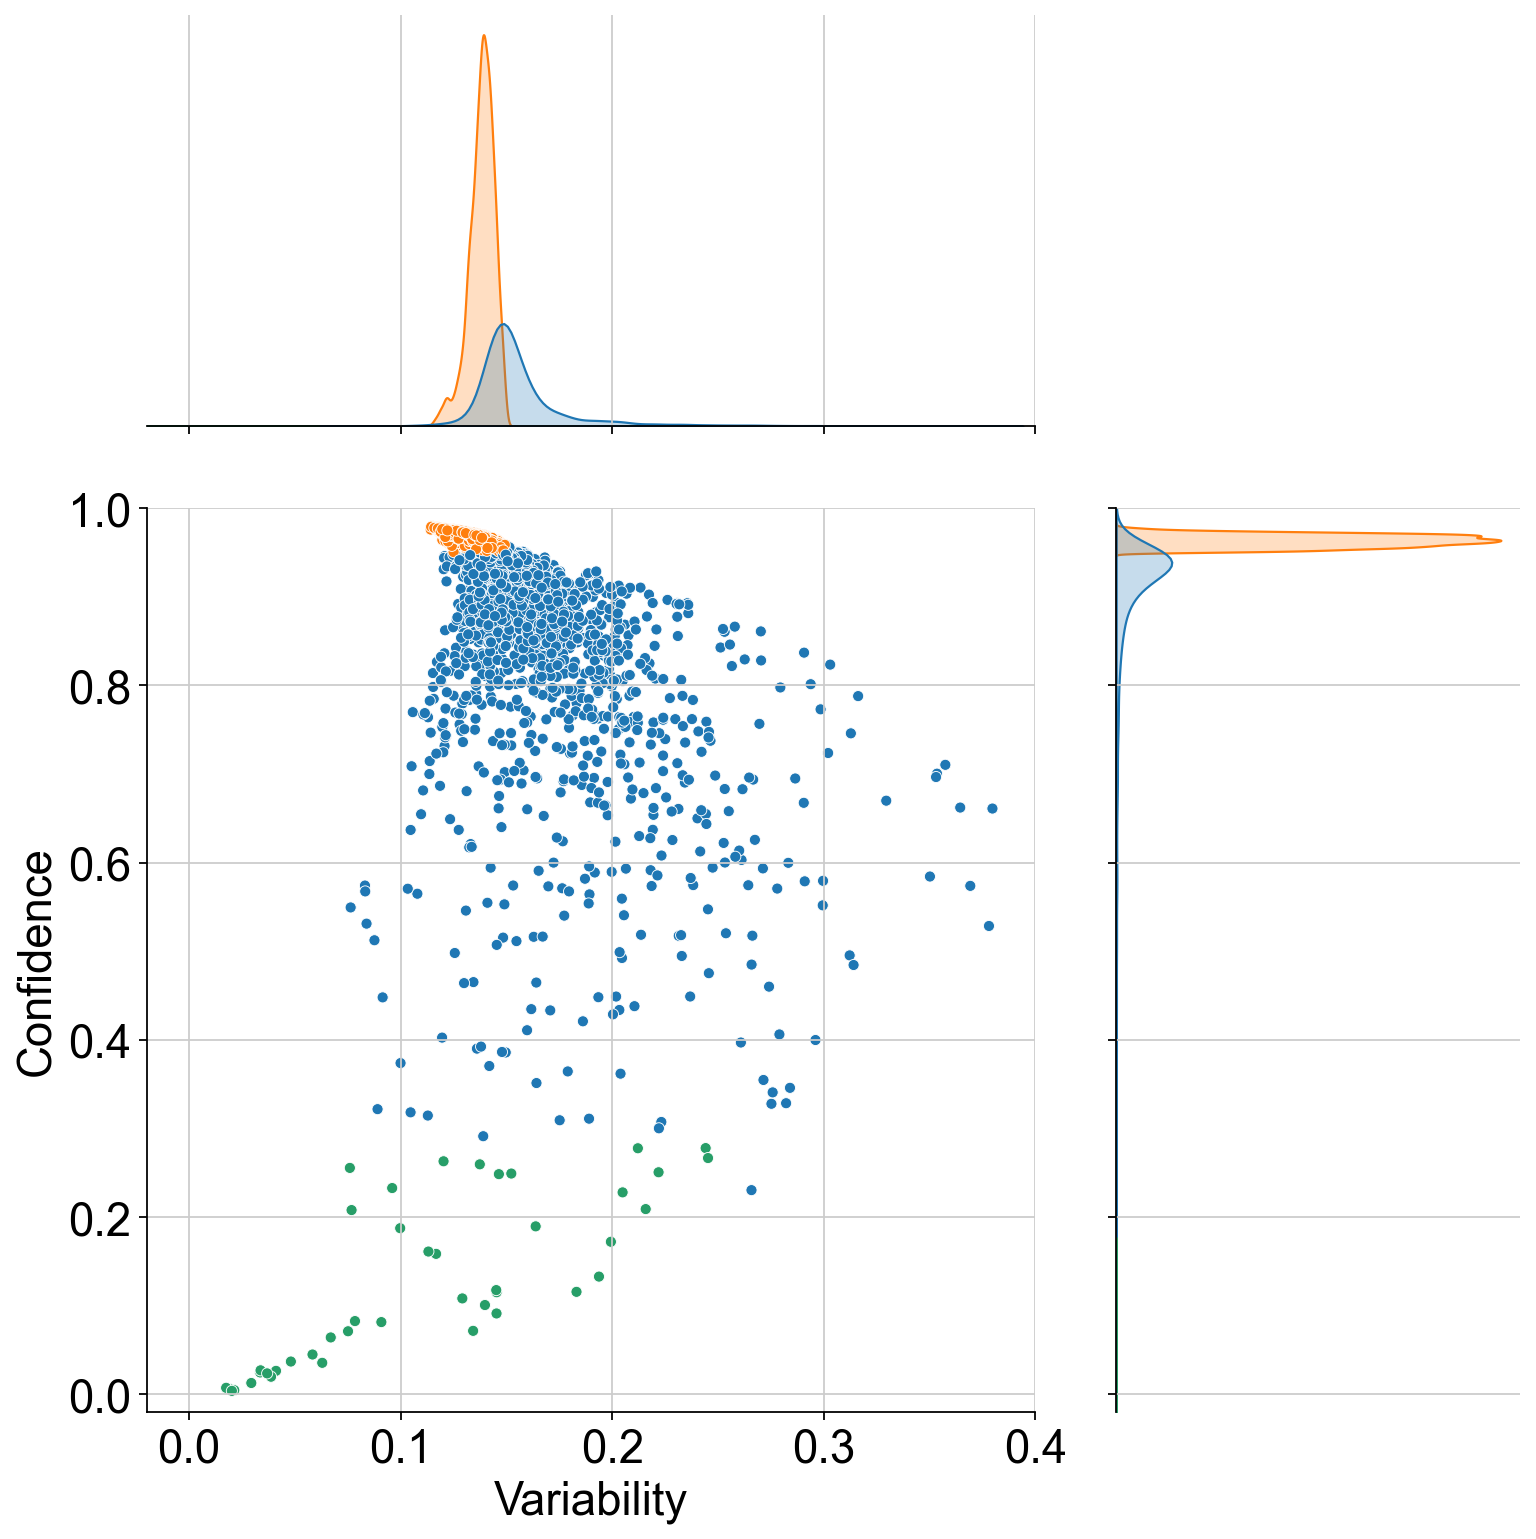

In [23]:
adata.obs['conf_non_ambiguous'] = pd.Categorical((adata.obs['conf'] > 0.95) | (adata.obs['var'] < 0.15))
adata.obs['Confidence']= adata.obs['conf']
adata.obs['Variability']= adata.obs['var']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue=' ',height=10,  s=25, ratio=2,
                    xlim=[-0.02,0.4], ylim=[-0.02,1])
#plt.legend(bbox_to_anchor=(2.02, 2), loc='upper left', borderaxespad=0)
#sns.set_style(style='white')
fig.ax_joint.legend_.remove()

plt.show(fig)

In [24]:
gene_mapping = {
    'ENSG00000168685': 'IL7R',
    'ENSG00000126353': 'CCR7',
    'ENSG00000196154': 'S100A4',
    'ENSG00000105369': 'CD79A',
    'ENSG00000153563': 'CD8A',
    'ENSG00000170458': 'CD14',
    'ENSG00000131981': 'LGALS3',
    'ENSG00000105374': 'NKG7',
    'ENSG00000111796': 'KLRB1',
    'ENSG00000179639': 'FCER1A',
    'ENSG00000101439': 'CST3',
    'ENSG00000163736': 'PPBP',
    'ENSG00000116824': 'CD2',
    'ENSG00000188404': 'SELL',
    'ENSG00000111537': 'IFNG',
    'ENSG00000168329': 'CX3CR1',
    'ENSG00000160255': 'ITGB2',
    'ENSG00000125498': 'KIR2DL1',
    'ENSG00000243772': 'KIR2DL3',
    'ENSG00000139187': 'KLRG1',
    'ENSG00000180644': 'PRF1',
    'ENSG00000145649': 'GZMA',
    'ENSG00000100453': 'GZMB',
    'ENSG00000163221': 'S100A12',
    'ENSG00000132965': 'ALOX5AP',
    'ENSG00000178623': 'GPR35',
    'ENSG00000019169': 'MARCO',
    'ENSG00000105371': 'ICAM4',
    'ENSG00000007312': 'CD79b',
}



/Users/jonathankarin/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


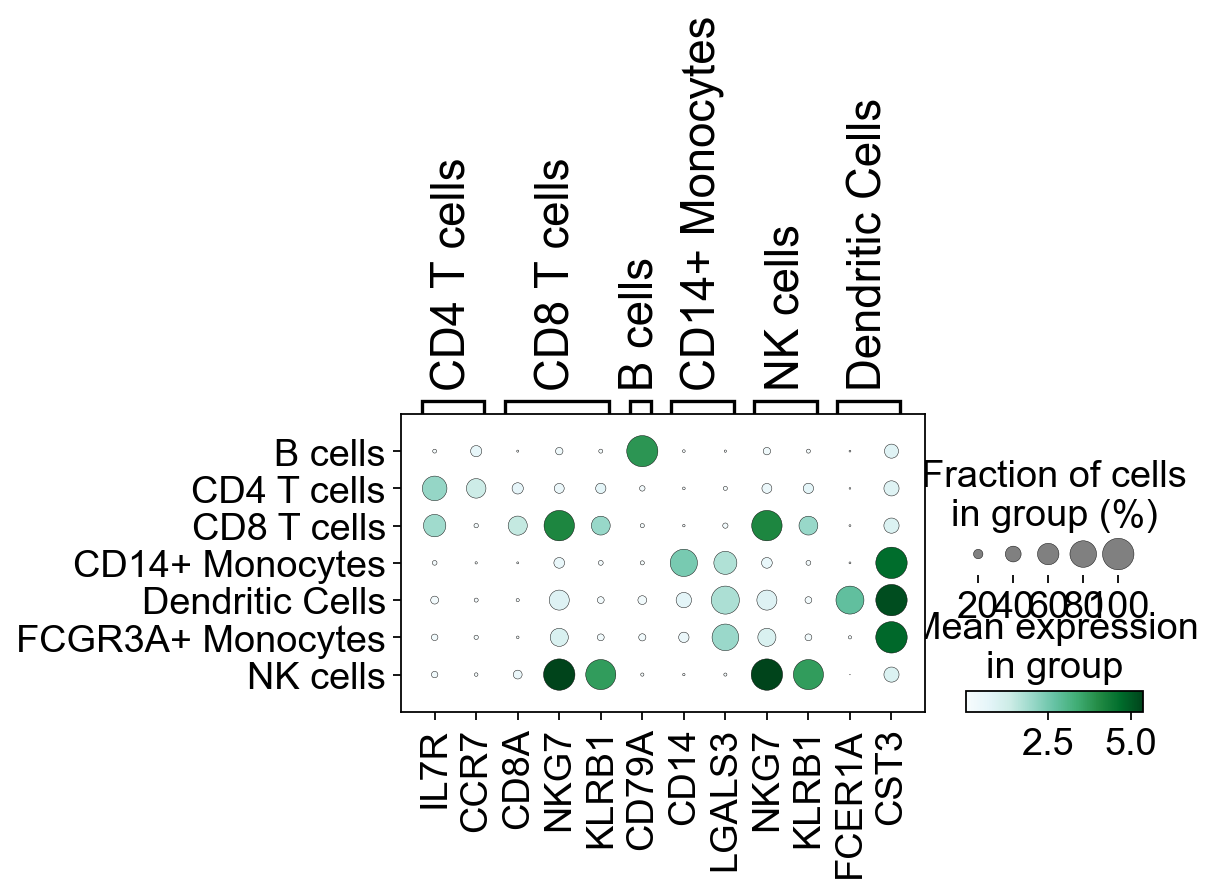

In [25]:
adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
adata.var['alt_names'].loc['ENSG00000196154']='S100A4'
adata.var['alt_names'].loc['ENSG00000105369']='CD79A'
adata.var['alt_names'].loc['ENSG00000153563']='CD8A'
adata.var['alt_names'].loc['ENSG00000170458']='CD14'
adata.var['alt_names'].loc['ENSG00000131981']='LGALS3'
adata.var['alt_names'].loc['ENSG00000105374']='NKG7'
adata.var['alt_names'].loc['ENSG00000111796']='KLRB1'
adata.var['alt_names'].loc['ENSG00000179639']='FCER1A'
adata.var['alt_names'].loc['ENSG00000101439']='CST3'
adata.var['alt_names'].loc['ENSG00000163736']='PPBP'
adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
adata.var['alt_names'].loc['ENSG00000188404']='SELL'
adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

marker_genes_dict= {
    'CD4 T cells':['IL7R','CCR7'],
    'CD8 T cells':['CD8A','NKG7','KLRB1'],
    'B cells':['CD79A'],
    'CD14+ Monocytes':['CD14','LGALS3'],
    'NK cells':['NKG7','KLRB1'],
    'Dendritic Cells':['FCER1A','CST3']}
    

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='str_labels', gene_symbols='alt_names', cmap='BuGn')


In [26]:
corr_classified_list =[]
for i in range(adata.n_obs):
    if adata.obs['conf_binaries'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Erroneous')
adata.obs['annotation']=corr_classified_list

FCGR3A+ Monocytes


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


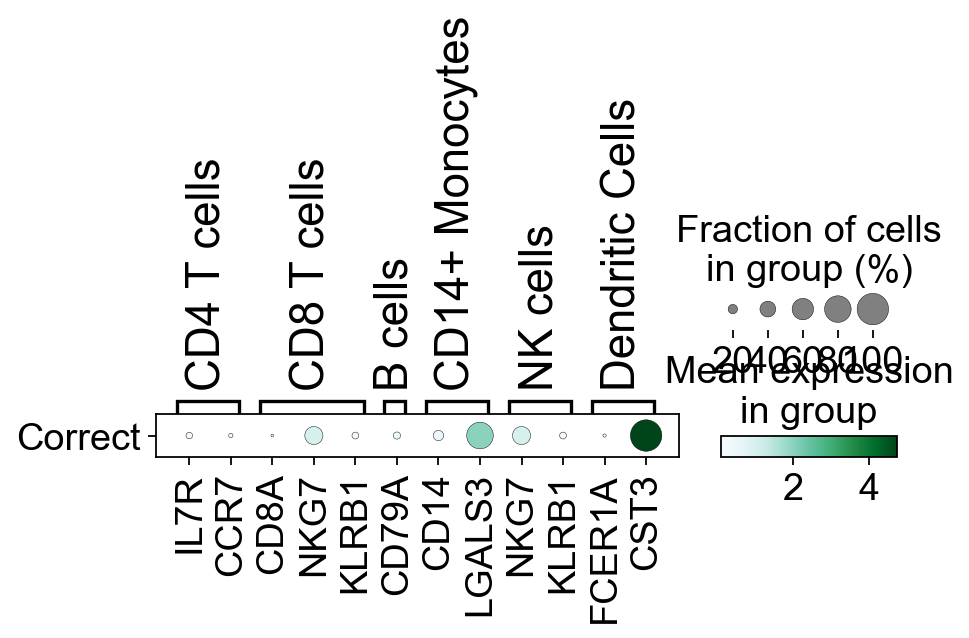

CD14+ Monocytes


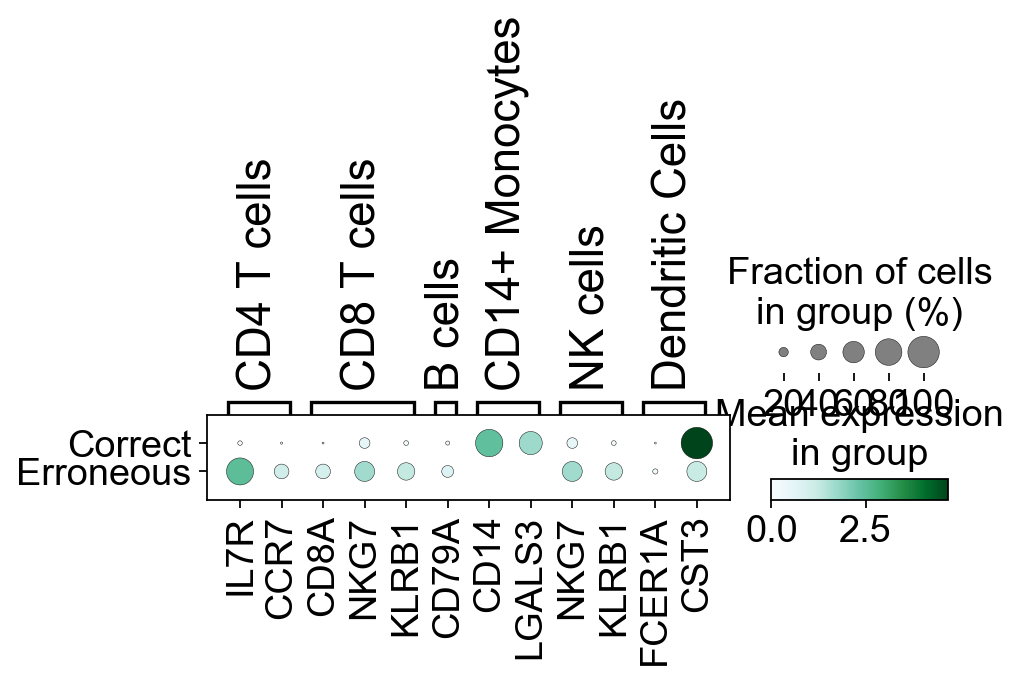

CD8 T cells


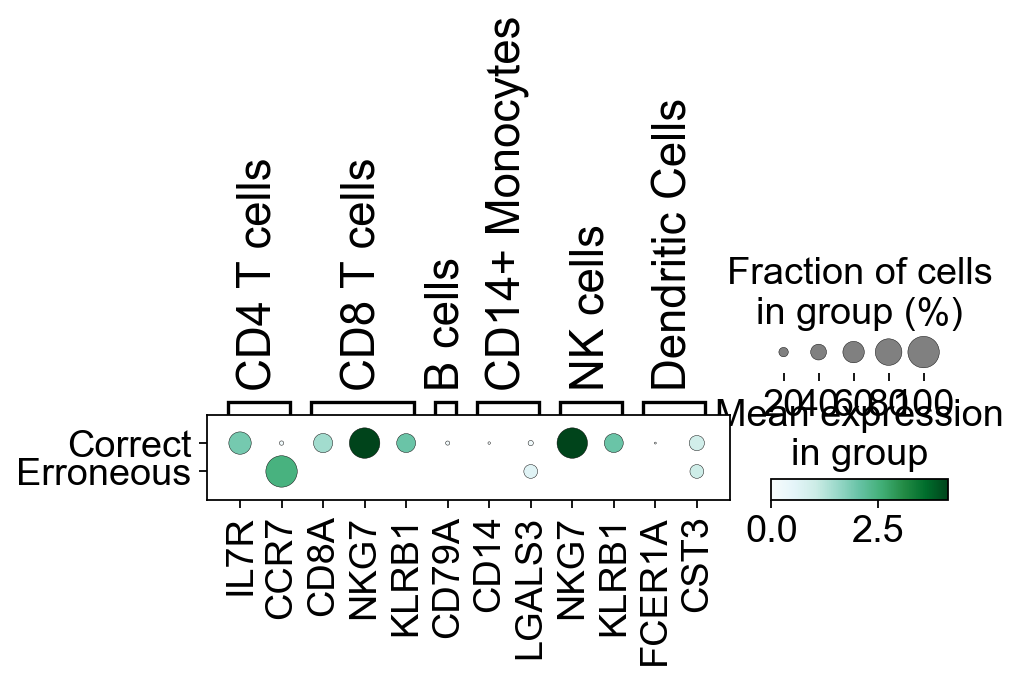

B cells


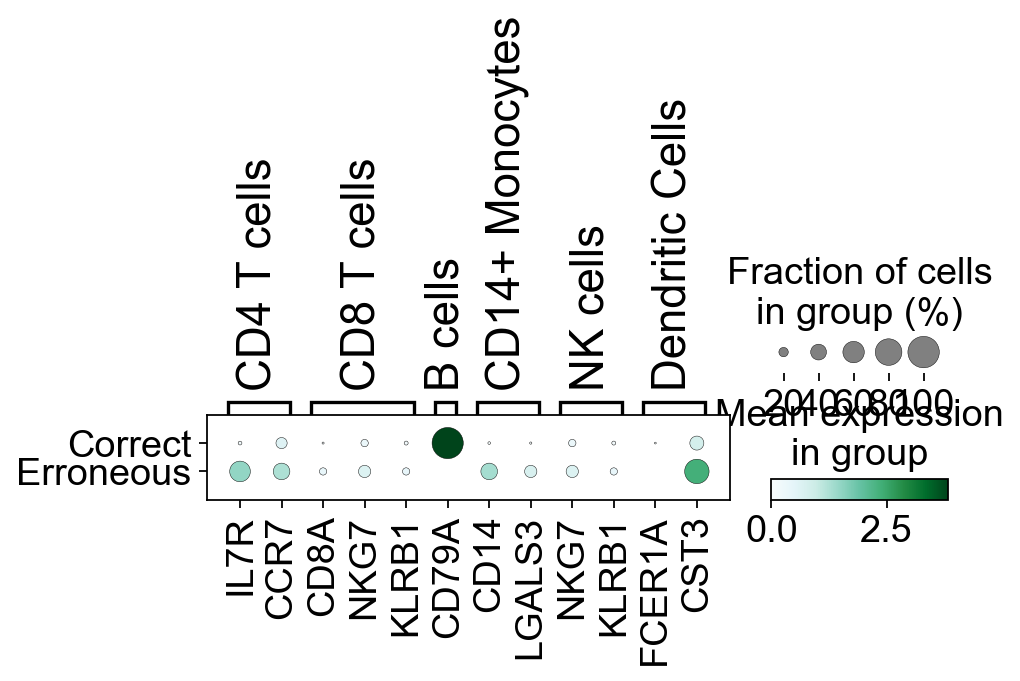

NK cells


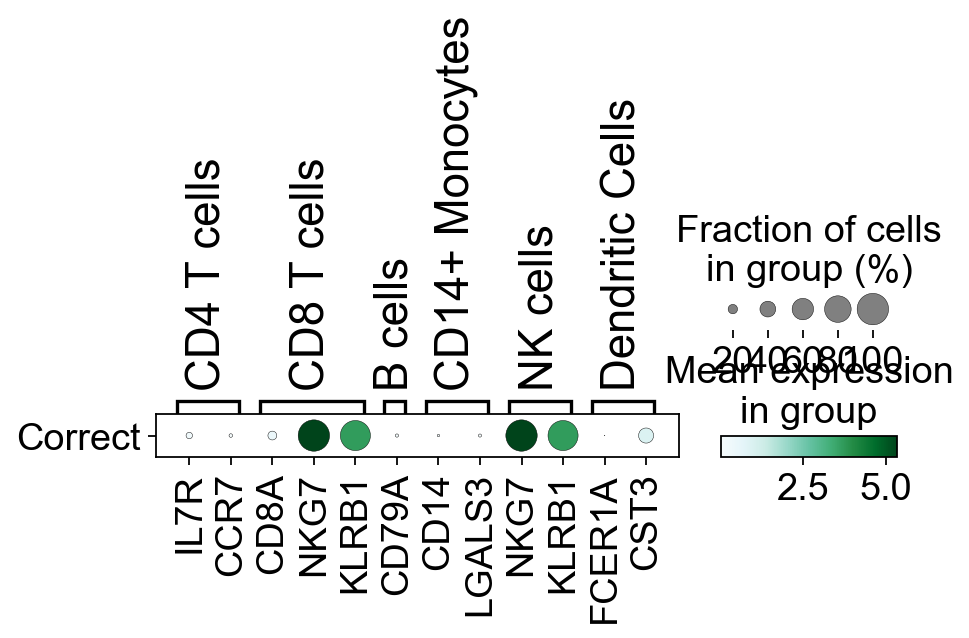

Dendritic Cells


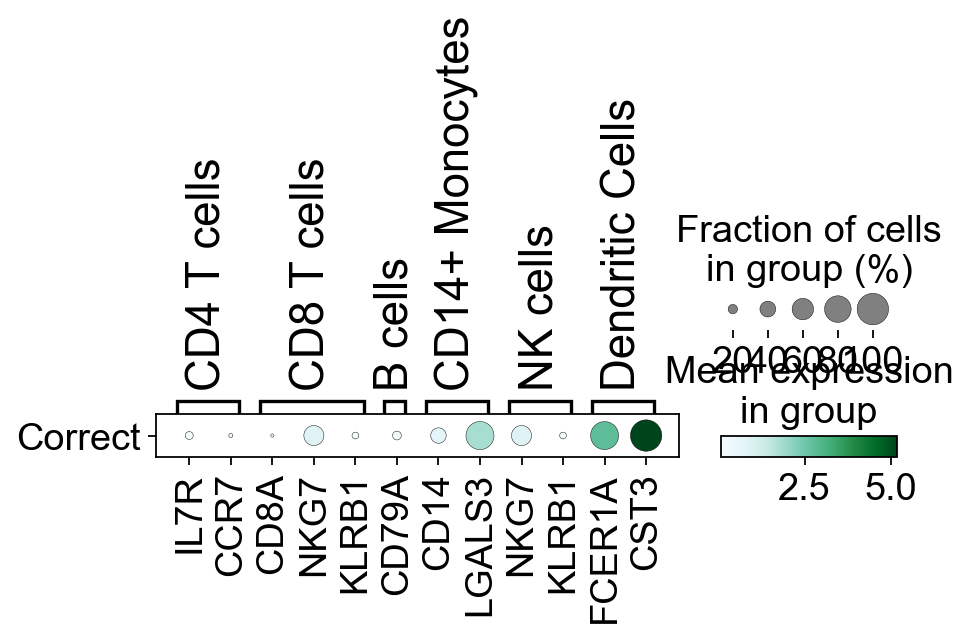

CD4 T cells


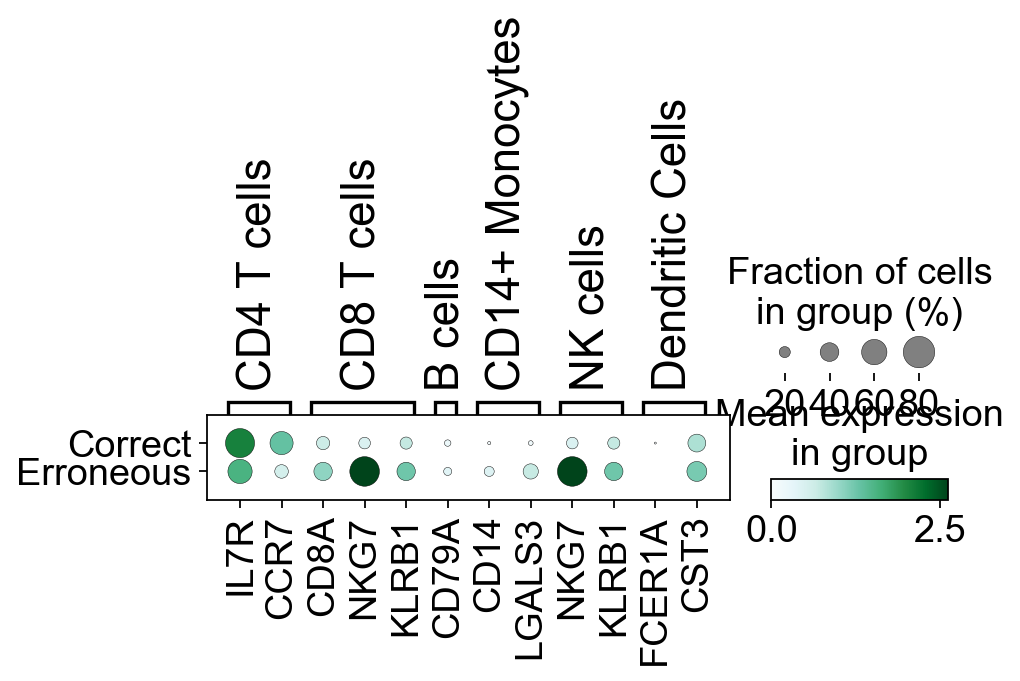

In [27]:

for celltype in set(adata.obs['str_labels']):
    adata_tmp= adata[adata.obs['str_labels'].isin([celltype])]
    print(celltype)
    
    ax = sc.pl.dotplot(adata_tmp, marker_genes_dict, groupby='annotation',cmap='BuGn', gene_symbols='alt_names')


In [28]:
adata_scaled.obs['conf']= adata.obs['conf']
adata_scaled.obs['var']= adata.obs['var']
adata_scaled.obs['conf_binaries']= adata.obs['conf_binaries']

In [29]:
cd56_genes_dict= {
    'CD56 bright':['IL7R','CCR7','CD2','SELL'], 
    'CD56 dim':['CX3CR1','ITGB2','KIR2DL1','KIR2DL3','KLRG1','PRF1','GZMA','GZMB'],     

                   }


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3305067191.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk_cd8.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk_cd8.obs['conf'] > 0.95) | (adata_nk_cd8.obs['var'] < 0.15))


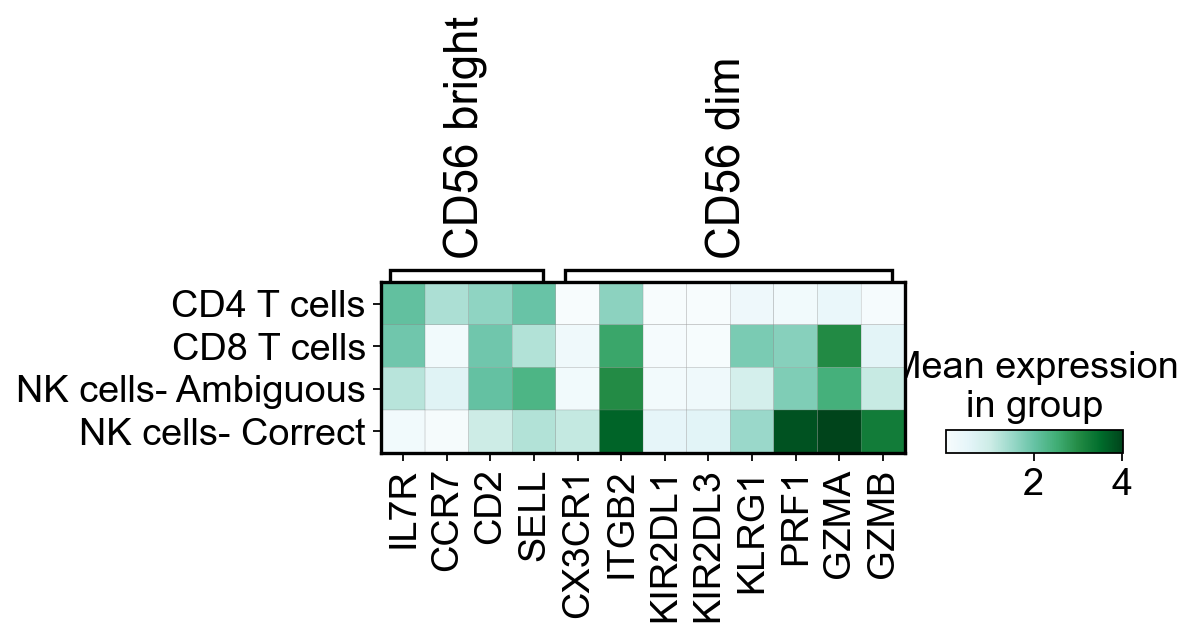

In [30]:
adata_nk_cd8= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk_cd8= adata_nk_cd8[adata_nk_cd8.obs['str_labels'].isin(['NK cells','CD8 T cells','CD4 T cells'])]


adata_nk_cd8.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk_cd8.obs['conf'] > 0.95) | (adata_nk_cd8.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk_cd8.n_obs):
    if adata_nk_cd8.obs['str_labels'][i]=='CD8 T cells':
        corr_classified_list.append('CD8 T cells')
    elif adata_nk_cd8.obs['str_labels'][i]=='CD4 T cells':
        corr_classified_list.append('CD4 T cells')
    else:
        if adata_nk_cd8.obs['conf_non_ambiguous'][i]==True:
            corr_classified_list.append('NK cells- Correct')
        else: 
            corr_classified_list.append('NK cells- Ambiguous')
adata_nk_cd8.obs['amb_annotation']=corr_classified_list

ax = sc.pl.matrixplot(adata_nk_cd8, cd56_genes_dict, groupby='amb_annotation',cmap='BuGn', gene_symbols='alt_names')



/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3177547120.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))


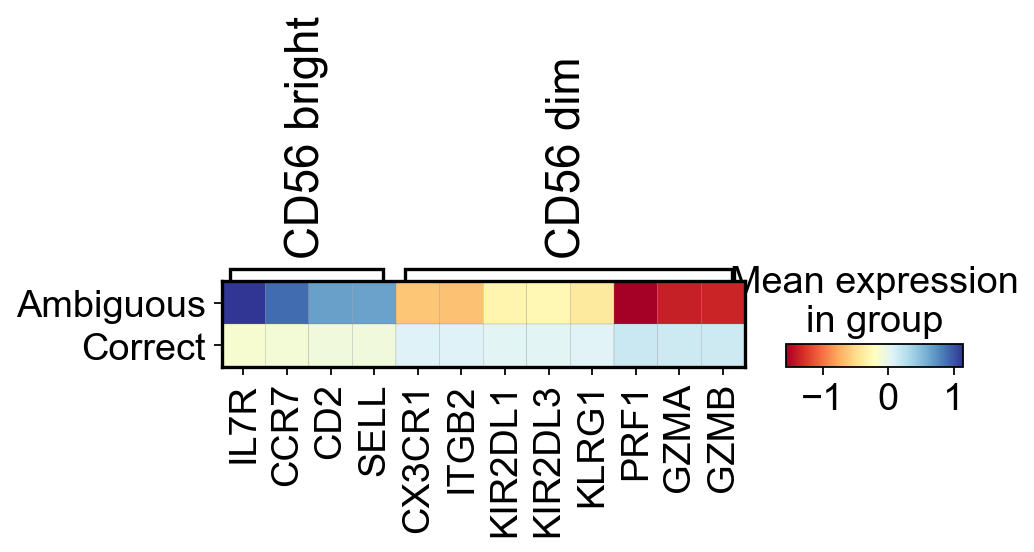

In [31]:
adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')



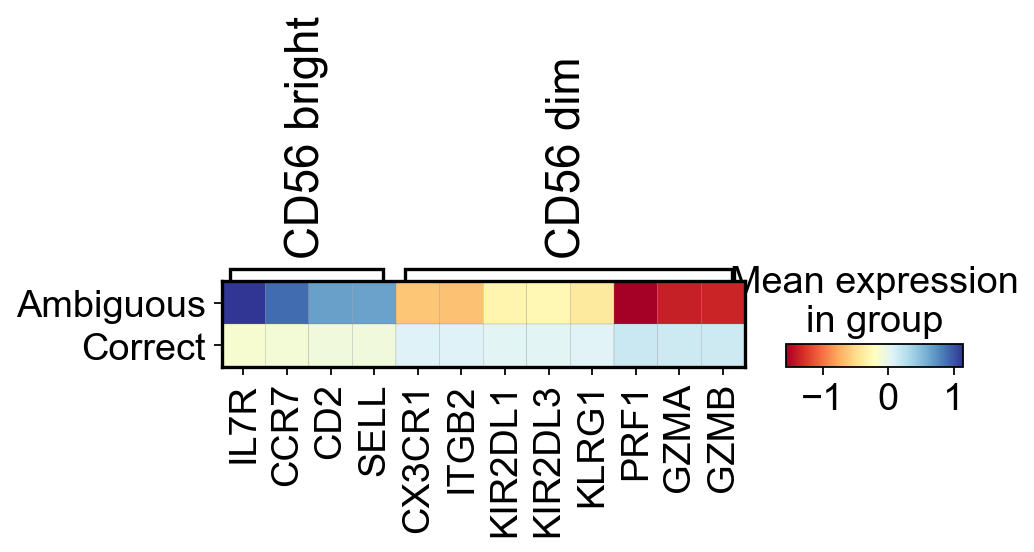

In [32]:
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')


In [33]:
adata_nk.obs['conf_non_ambiguous'].value_counts()

True     410
False     47
Name: conf_non_ambiguous, dtype: int64

In [34]:
bdata= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= bdata[bdata.obs['str_labels'].isin(['NK cells'])]
adata_cd4= bdata[bdata.obs['str_labels'].isin(['CD4 T cells'])]
adata_cd8= bdata[bdata.obs['str_labels'].isin(['CD8 T cells'])]
adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))
adata_nk_cells_non_ambiguous= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([True])]
adata_nk_cells_ambiguou= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([False])]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2042883637.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))


In [35]:
mean_non_ambiguous = np.mean(adata_nk_cells_non_ambiguous.X , axis=0)
mean_ambiguous = np.mean(adata_nk_cells_ambiguou.X , axis=0)
mean_cd8 = np.mean(adata_cd8.X , axis=0)
mean_cd4 = np.mean(adata_cd4.X , axis=0)

print(np.linalg.norm(mean_non_ambiguous-mean_ambiguous))
print(np.linalg.norm(mean_non_ambiguous-mean_cd8))
print(np.linalg.norm(mean_non_ambiguous-mean_cd4))
print(np.linalg.norm(mean_cd8-mean_ambiguous))
print(np.linalg.norm(mean_cd4-mean_ambiguous))


12.250724
13.778523
20.348095
10.118591
13.55198


In [36]:
A = np.zeros((4,4))
#mean_non_ambiguous -0
#mean_ambiguous -1
#mean_cd8 -2
#mean_cd4 -3

A[0,1]= np.linalg.norm(mean_non_ambiguous-mean_ambiguous)
A[0,2]= np.linalg.norm(mean_non_ambiguous-mean_cd8)
A[0,3]= np.linalg.norm(mean_non_ambiguous-mean_cd4)
A[1,0]= A[0,1]
A[1,2]= np.linalg.norm(mean_ambiguous-mean_cd8)
A[1,3]= np.linalg.norm(mean_ambiguous-mean_cd4)
A[2,0]= A[0,2]
A[2,1]= A[1,2]
A[2,3]= np.linalg.norm(mean_cd8-mean_cd4)
A[3,0]= A[0,3]
A[3,1]= A[1,3]
A[3,2]= A[2,3]


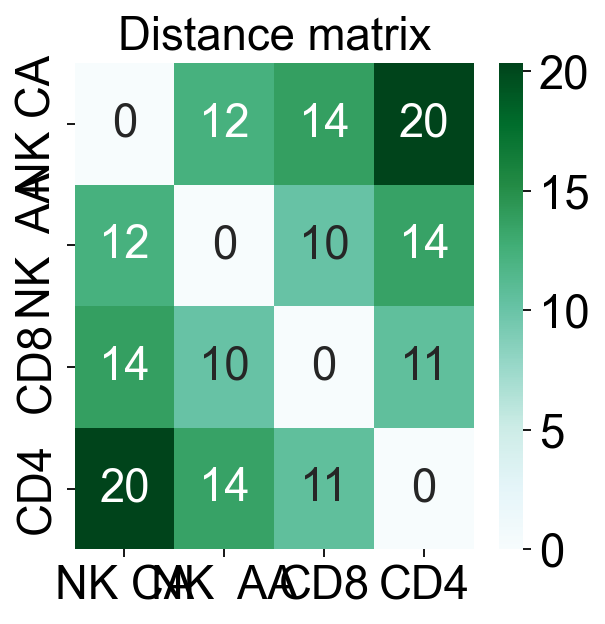

In [37]:
import seaborn as sns
g = sns.heatmap(A, annot=True,cmap='BuGn')
g.set_xticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_yticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_title('Distance matrix')
plt.show()

In [38]:
celltype_list= ["CD14+ Monocytes", "FCGR3A+ Monocytes"]#,'Dendritic Cells']
adata_monocytes= adata[adata.obs['conf_binaries'].isin([True])]
adata_monocytes= adata_monocytes[adata_monocytes.obs['str_labels'].isin(celltype_list)]
adata_monocytes.obs['non_conf_ambiguous'] = pd.Categorical((adata_monocytes.obs['conf'] > 0.95) &
                                                     (adata_monocytes.obs['var'] < 0.15))

adata_monocytes_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_monocytes_scaled= adata_monocytes_scaled[adata_monocytes_scaled.obs['str_labels'].isin(celltype_list)]
adata_monocytes_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_monocytes_scaled.obs['conf'] > 0.95) &
                                                     (adata_monocytes_scaled.obs['var'] < 0.15))


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3795385936.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_monocytes.obs['non_conf_ambiguous'] = pd.Categorical((adata_monocytes.obs['conf'] > 0.95) &
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3795385936.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_monocytes_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_monocytes_scaled.obs['conf'] > 0.95) &


In [39]:

adata_scaled.obs['conf']=adata.obs['conf']
adata_scaled.obs['var']=adata.obs['var']

adata_cd14_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_cd14_scaled= adata_cd14_scaled[adata_cd14_scaled.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_cd14_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) &
                                                     (adata_cd14_scaled.obs['var'] < 0.15))

adata_fc_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_fc_scaled= adata_fc_scaled[adata_fc_scaled.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]
adata_fc_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) &
                                                     (adata_fc_scaled.obs['var'] < 0.15))


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3374285711.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) &
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3374285711.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) &


In [40]:
adata_cd14_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) | (adata_cd14_scaled.obs['var'] < 0.15))
adata_fc_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) | (adata_fc_scaled.obs['var'] < 0.15))
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/271848444.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['cell_state']=annotation_list_cd14
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/271848444.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['cell_state']=annotation_list_fc
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


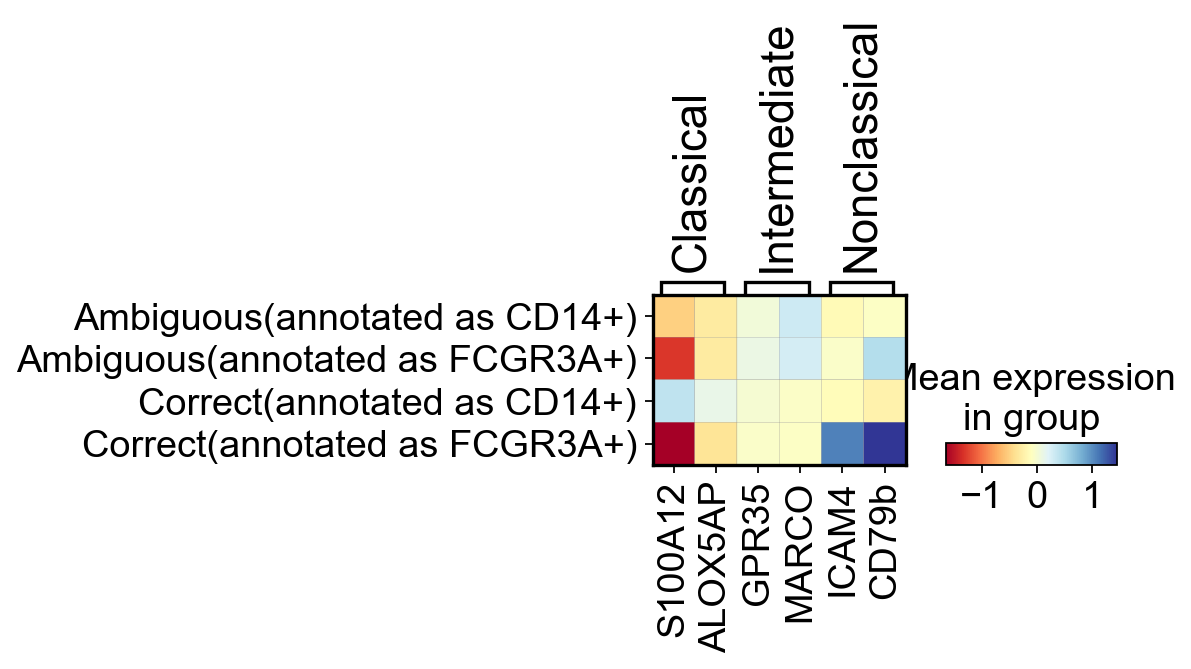

In [41]:

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


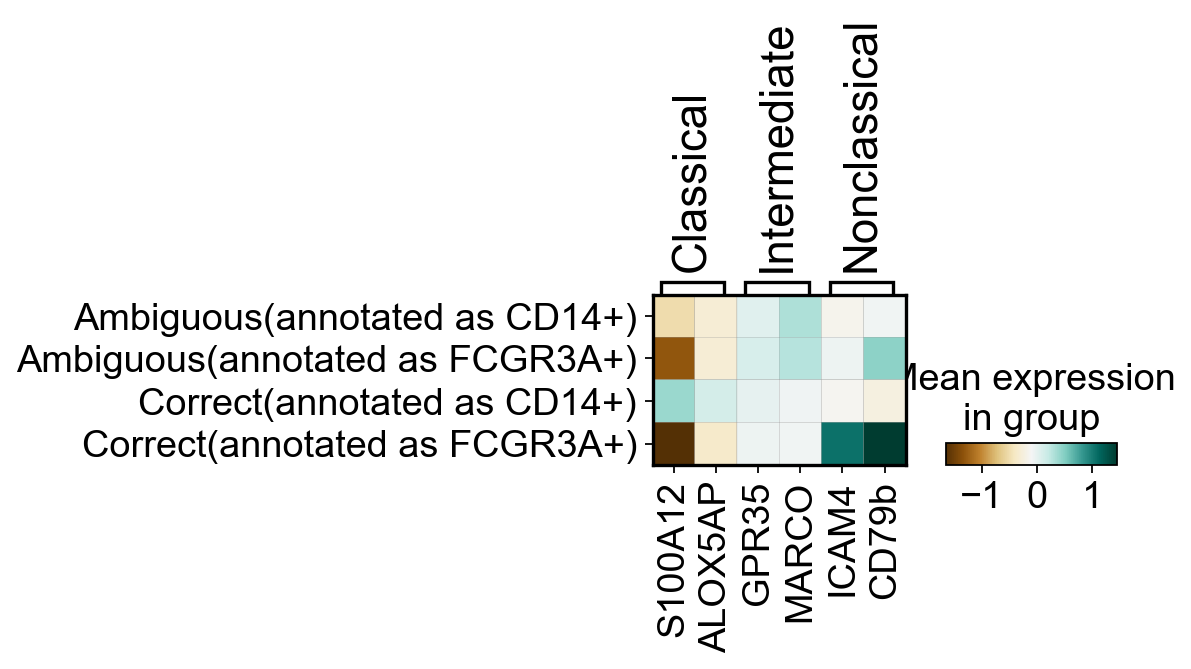

In [42]:
ax = sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state',cmap='BrBG', gene_symbols='alt_names')



In [43]:
adata_monocytes.obs['conf_non_ambiguos'] = pd.Categorical((adata_monocytes.obs['conf'] > 0.95) &
                                                     (adata_monocytes.obs['var'] < 0.15))
cd14_= adata_monocytes[adata_monocytes.obs['str_labels'].isin(['CD14+ Monocytes'])]
sc.tl.rank_genes_groups(cd14_,'conf_non_ambiguos','wilcoxon')

fc_= adata_monocytes[adata_monocytes.obs['str_labels'].isin(['FCGR3A+ Monocytes'])]
sc.tl.rank_genes_groups(fc_,'conf_non_ambiguos', 'wilcoxon')



In [44]:
#adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
#adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
#adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
#adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
#adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
#adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

def get_gene_pvalue(adata, gene):
    for i, j in enumerate(adata.uns['rank_genes_groups']['names']):
        if j[0]==gene:
            print(adata.uns['rank_genes_groups']['pvals'][i])
    adata_amb= adata[adata.obs['conf_non_ambiguos'].isin([False])]
    print(np.mean(adata_amb[:,gene].X.toarray()))
    adata_cor= adata[adata.obs['conf_non_ambiguos'].isin([True])]
    print(np.mean(adata_cor[:,gene].X.toarray()))


print(get_gene_pvalue(cd14_,'ENSG00000163221'))
print(get_gene_pvalue(cd14_,'ENSG00000132965'))
print(get_gene_pvalue(cd14_,'ENSG00000178623'))
print(get_gene_pvalue(cd14_,'ENSG00000019169'))

print("******* ")
print(get_gene_pvalue(fc_,'ENSG00000105371'))
print(get_gene_pvalue(fc_,'ENSG00000007312'))
print(get_gene_pvalue(fc_,'ENSG00000178623'))
print(get_gene_pvalue(fc_,'ENSG00000019169'))


(1.30660976e-83, 9.45961355e-145)
2.463245
3.8520248
None
(9.49013274e-21, 3.913926e-28)
0.2975781
0.6863867
None
(0.07126147, 0.29677246)
0.14924362
0.10522713
None
(5.80890487e-08, 0.11860547)
0.41237742
0.20281795
None
******* 
(2.233519e-11, 2.76727821e-14)
0.118131
0.6552501
None
(1.40249047e-06, 0.00047702)
0.9269023
1.6204582
None
(0.17368429, 0.00523244)
0.16863492
0.08382745
None
(0.00217547, 2.25944254e-06)
0.5024052
0.16739927
None


In [46]:
intermediate_state_mapping = {
    'B cells': 'B cells',
    'CD4 T cells': 'CD4 T cells',
    'CD8 T cells': 'NK cells',
    'FCGR3A+ Monocytes': 'CD14+ Monocytes',
    'CD14+ Monocytes': 'FCGR3A+ Monocytes',
    'Dendritic Cells': 'Dendritic Cells',
    'NK cells': 'CD8 T cells'
}

# Create an empty list to store the updated cell types
cell_type_list = []
for i in range(adata.n_obs):
    cluster_name = adata.obs['str_labels'][i]
    if cluster_name in intermediate_state_mapping:
        cell_type_list.append(intermediate_state_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['str_labels_2'] = np.array(cell_type_list)
epoch_num=100
prob_list_1, prob_list_2 = models.follow_train_dyn_two_lables(adata, label_one='str_labels', label_two= 'str_labels_2', iterNum=epoch_num, device=device)

[1,     2] loss: 0.391
[1,    12] loss: 1.930
[1,    22] loss: 1.863
[1,    32] loss: 1.788
[1,    42] loss: 1.697
[2,     2] loss: 0.318
[2,    12] loss: 1.516
[2,    22] loss: 1.390
[2,    32] loss: 1.227
[2,    42] loss: 1.073
[3,     2] loss: 0.191
[3,    12] loss: 0.872
[3,    22] loss: 0.757
[3,    32] loss: 0.647
[3,    42] loss: 0.588
[4,     2] loss: 0.109
[4,    12] loss: 0.502
[4,    22] loss: 0.432
[4,    32] loss: 0.397
[4,    42] loss: 0.346
[5,     2] loss: 0.061
[5,    12] loss: 0.307
[5,    22] loss: 0.292
[5,    32] loss: 0.270
[5,    42] loss: 0.243
[6,     2] loss: 0.046
[6,    12] loss: 0.230
[6,    22] loss: 0.213
[6,    32] loss: 0.185
[6,    42] loss: 0.194
[7,     2] loss: 0.038
[7,    12] loss: 0.180
[7,    22] loss: 0.184
[7,    32] loss: 0.159
[7,    42] loss: 0.145
[8,     2] loss: 0.035
[8,    12] loss: 0.155
[8,    22] loss: 0.150
[8,    32] loss: 0.150
[8,    42] loss: 0.146
[9,     2] loss: 0.031
[9,    12] loss: 0.147
[9,    22] loss: 0.137
[9,    32] 

[69,    42] loss: 0.020
[70,     2] loss: 0.003
[70,    12] loss: 0.015
[70,    22] loss: 0.017
[70,    32] loss: 0.024
[70,    42] loss: 0.019
[71,     2] loss: 0.002
[71,    12] loss: 0.012
[71,    22] loss: 0.022
[71,    32] loss: 0.013
[71,    42] loss: 0.017
[72,     2] loss: 0.005
[72,    12] loss: 0.015
[72,    22] loss: 0.015
[72,    32] loss: 0.019
[72,    42] loss: 0.011
[73,     2] loss: 0.003
[73,    12] loss: 0.021
[73,    22] loss: 0.013
[73,    32] loss: 0.011
[73,    42] loss: 0.016
[74,     2] loss: 0.002
[74,    12] loss: 0.016
[74,    22] loss: 0.012
[74,    32] loss: 0.015
[74,    42] loss: 0.013
[75,     2] loss: 0.002
[75,    12] loss: 0.014
[75,    22] loss: 0.013
[75,    32] loss: 0.020
[75,    42] loss: 0.010
[76,     2] loss: 0.004
[76,    12] loss: 0.013
[76,    22] loss: 0.019
[76,    32] loss: 0.010
[76,    42] loss: 0.016
[77,     2] loss: 0.002
[77,    12] loss: 0.016
[77,    22] loss: 0.015
[77,    32] loss: 0.016
[77,    42] loss: 0.018
[78,     2] loss

In [47]:
for i in range(100):
    adata.obs['prob1_' +str(i)] = prob_list_1[i]
    adata.obs['prob2_' +str(i)] = prob_list_2[i]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/710060434.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['prob2_' +str(i)] = prob_list_2[i]
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/710060434.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['prob1_' +str(i)] = prob_list_1[i]


In [48]:
adata_cd14= adata[adata.obs['conf_binaries'].isin([True])]
adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.15))

adata_cd14= adata_cd14[adata_cd14.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_miss= adata[adata.obs['conf_binaries'].isin([False])]
adata_cd14_miss= adata_cd14_miss[adata_cd14_miss.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_inter= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([False])]
adata_cd14_cd14= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([True])]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/1208168020.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.15))


In [49]:

prob_cd14_cd14 = []
std_cd14_cd14 = []
prob_cd14_miss = []
std_cd14_miss = []
prob_inter_cd14 = []
std_inter_cd14 = []
prob_inter_fc = []
std_inter_fc = []

for i in range(100):
    prob_cd14_cd14.append(np.mean(adata_cd14_cd14.obs['prob1_' +str(i)]))
    prob_cd14_miss.append(np.mean(adata_cd14_miss.obs['prob1_' +str(i)]))
    prob_inter_cd14.append(np.mean(adata_cd14_inter.obs['prob1_' +str(i)]))
    prob_inter_fc.append(np.mean(adata_cd14_inter.obs['prob2_' +str(i)]))
    std_cd14_cd14.append(np.std(adata_cd14_cd14.obs['prob1_' +str(i)]))
    std_cd14_miss.append(np.std(adata_cd14_miss.obs['prob1_' +str(i)]))
    std_inter_cd14.append(np.std(adata_cd14_inter.obs['prob1_' +str(i)]))
    std_inter_fc.append(np.std(adata_cd14_inter.obs['prob2_' +str(i)]))



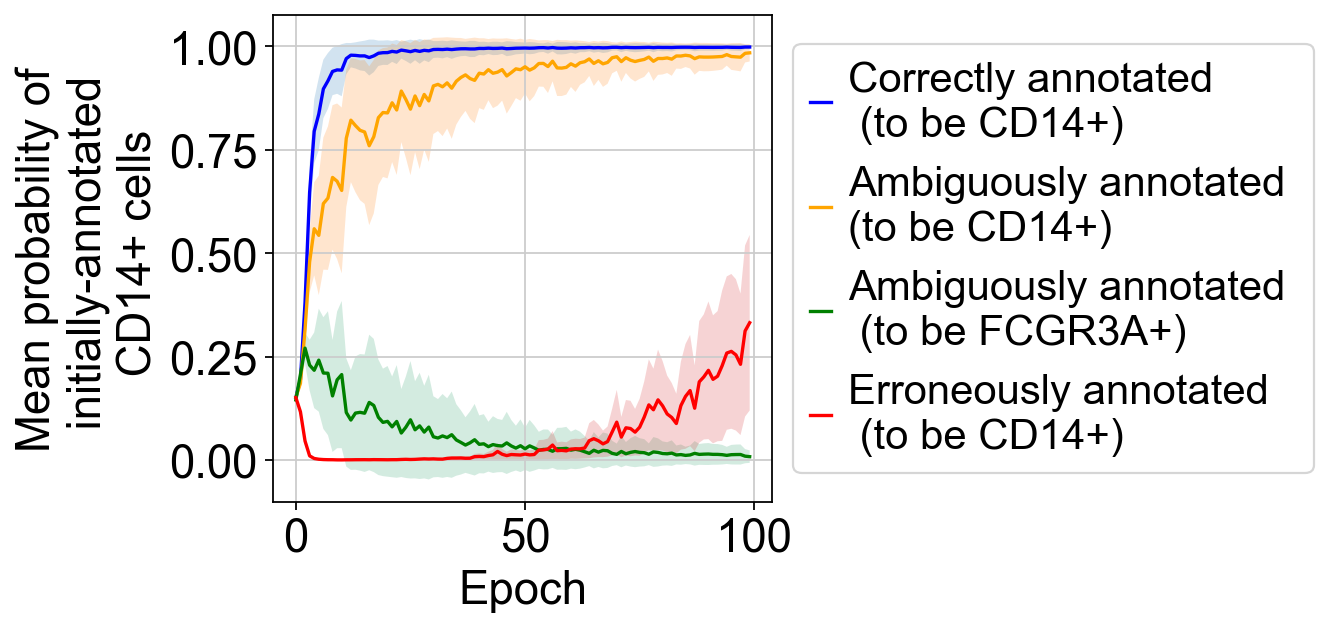

In [50]:
std_cd14_cd14 = np.array(std_cd14_cd14)
prob_cd14_cd14  = np.array(prob_cd14_cd14)
prob_inter_cd14 = np.array(prob_inter_cd14)
std_inter_cd14 = np.array(std_inter_cd14)
prob_inter_fc = np.array(prob_inter_fc)
std_inter_fc = np.array(std_inter_fc)
prob_cd14_miss = np.array(prob_cd14_miss)
std_cd14_miss = np.array(std_cd14_miss)

plt.plot(range(100),prob_cd14_cd14[:100],label='Correctly annotated\n (to be CD14+)', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='Ambiguously annotated \n(to be CD14+)', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='Ambiguously annotated\n (to be FCGR3A+)', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='Erroneously annotated\n (to be CD14+)', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Mean probability of\n initially-annotated\n CD14+ cells')
#plt.ylabel('Spacing of\nZeroes of\n$J_{\\nu}(x)$', rotation=0, ha="right")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



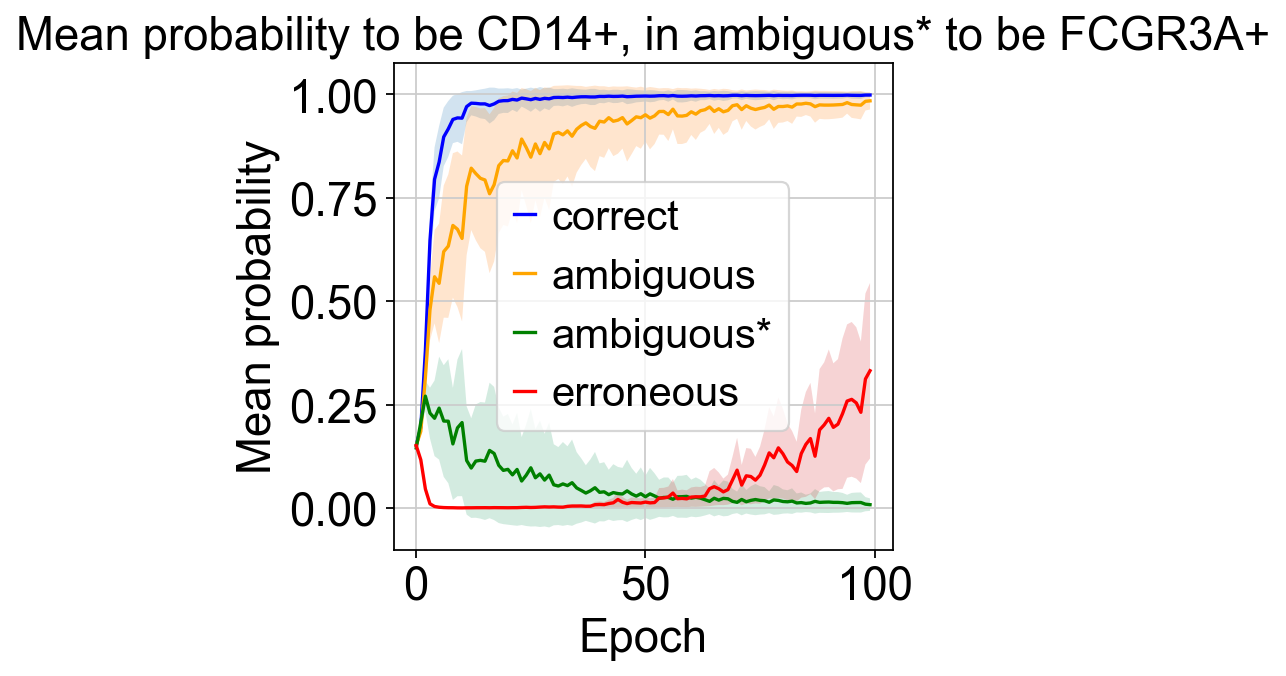

In [51]:
plt.plot(range(100),prob_cd14_cd14[:100],label='correct', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='ambiguous', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='ambiguous*', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='erroneous', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.title('Mean probability to be CD14+, in ambiguous* to be FCGR3A+')
plt.ylabel('Mean probability')
#plt.ylabel(' mean probability to be classical (CD14+), except in ambiguous*, it is the probability to be non-classical (FCGR3A+)')
plt.legend()
plt.show()



/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/1450802232.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.85) | (adata_cd14.obs['var'] < 0.15))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/1450802232.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.85) | (adata_fc.obs['var'] < 0.15))
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=

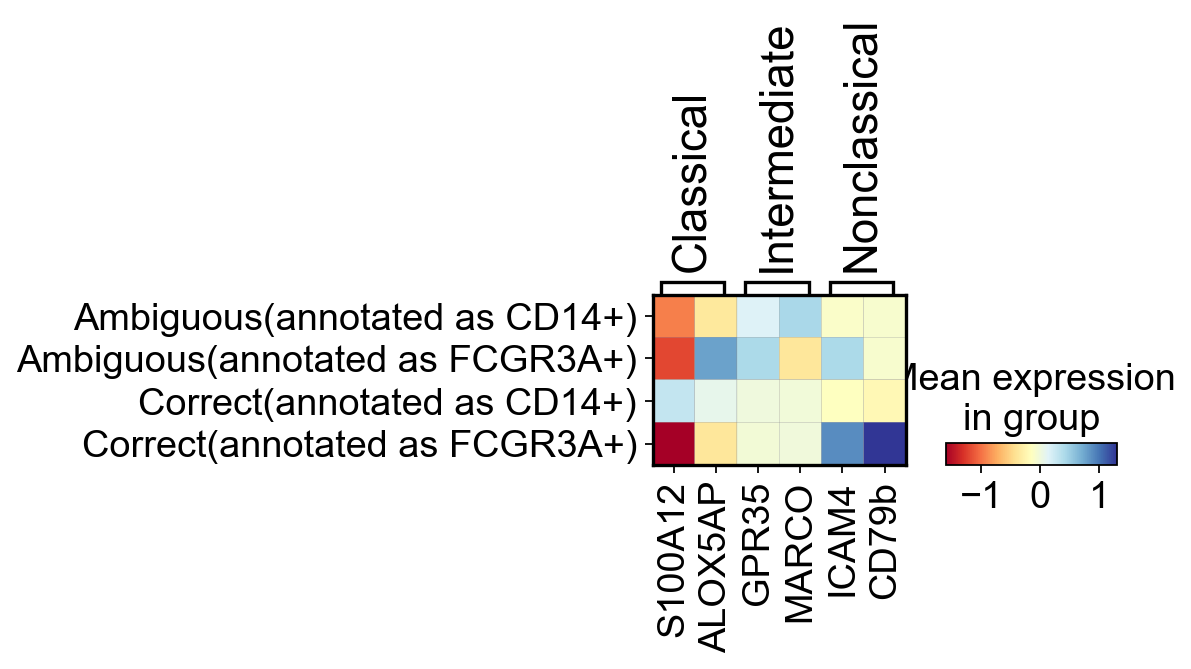

In [52]:
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.85) | (adata_cd14.obs['var'] < 0.15))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.85) | (adata_fc.obs['var'] < 0.15))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3501955311.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.8) | (adata_cd14.obs['var'] < 0.15))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3501955311.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.8) | (adata_fc.obs['var'] < 0.15))


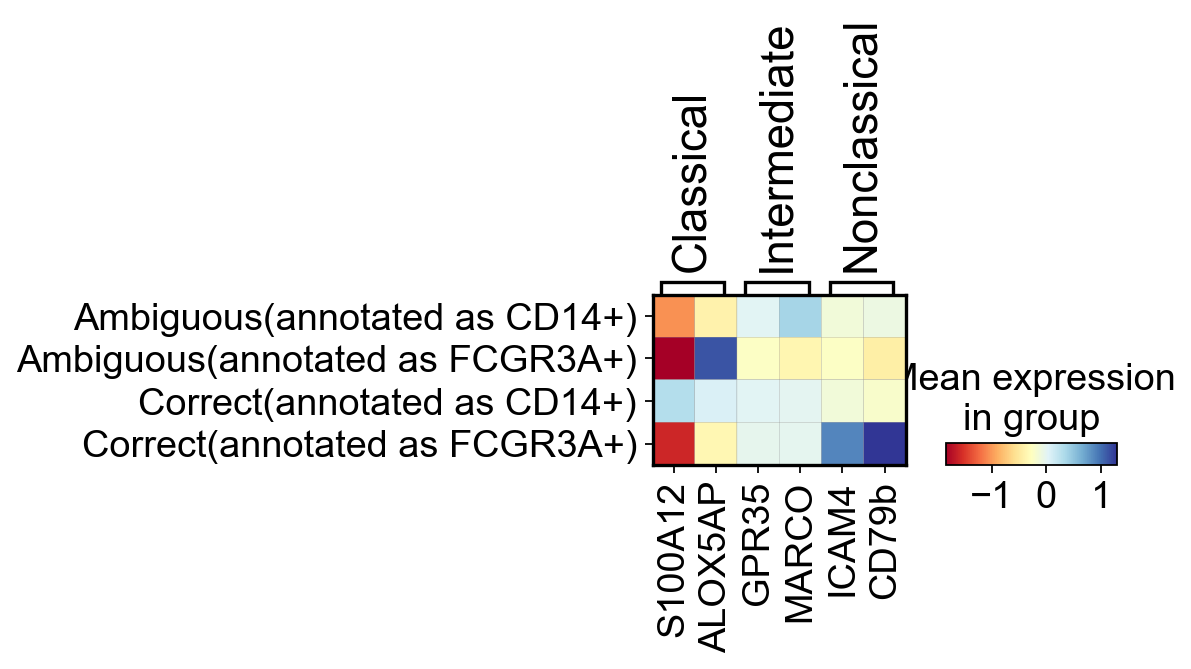

In [53]:
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.8) | (adata_cd14.obs['var'] < 0.15))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.8) | (adata_fc.obs['var'] < 0.15))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/185367449.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.7) | (adata_cd14.obs['var'] < 0.15))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/185367449.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.7) | (adata_fc.obs['var'] < 0.15))


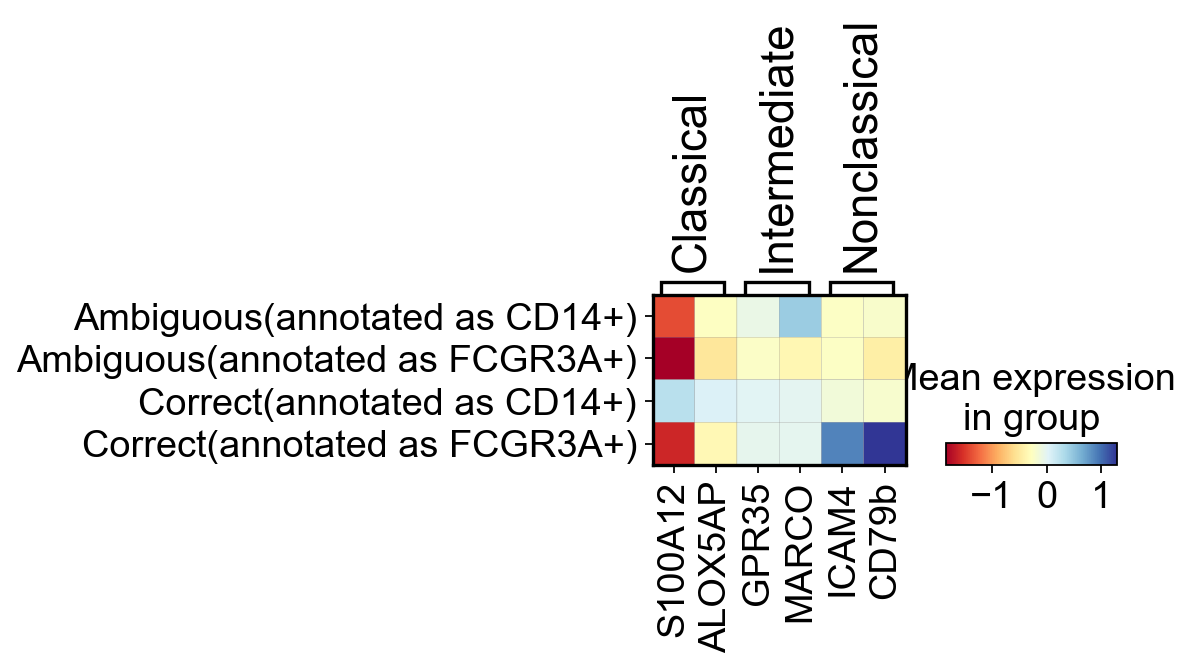

In [54]:
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.7) | (adata_cd14.obs['var'] < 0.15))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.7) | (adata_fc.obs['var'] < 0.15))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.7) | (adata_cd14.obs['var'] < 0.1))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.7) | (adata_fc.obs['var'] < 0.1))


0.7 0.1


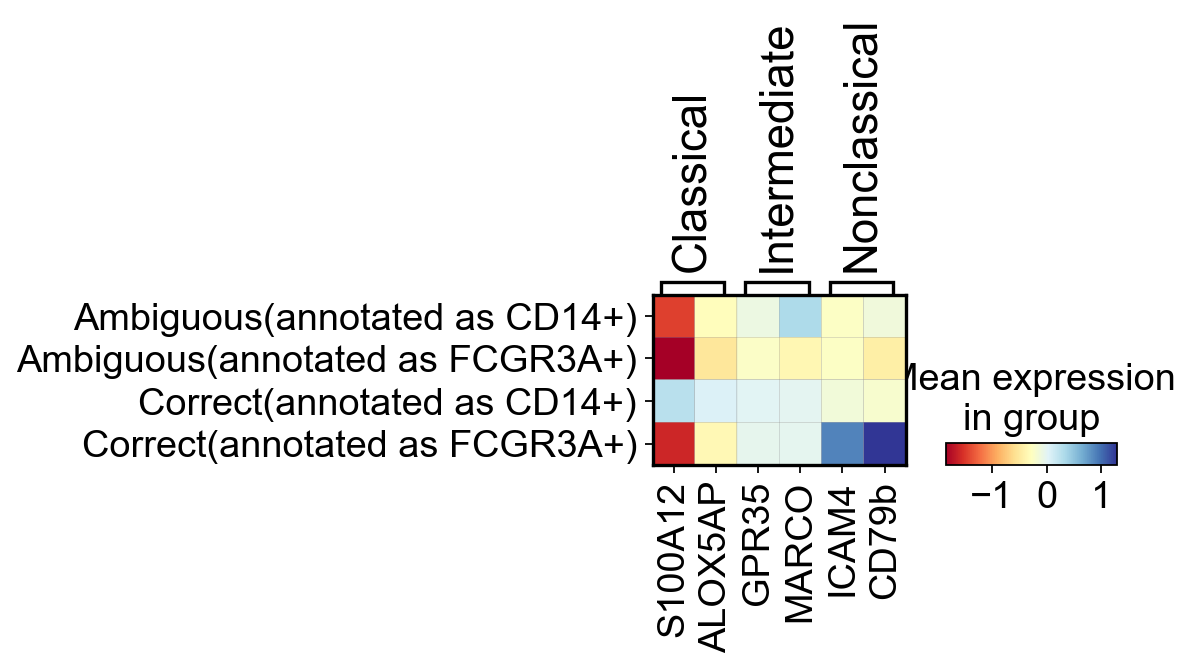

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:36: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.1))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:37: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.95) | (adata_fc.obs['var'] < 0.1))


0.95 0.1


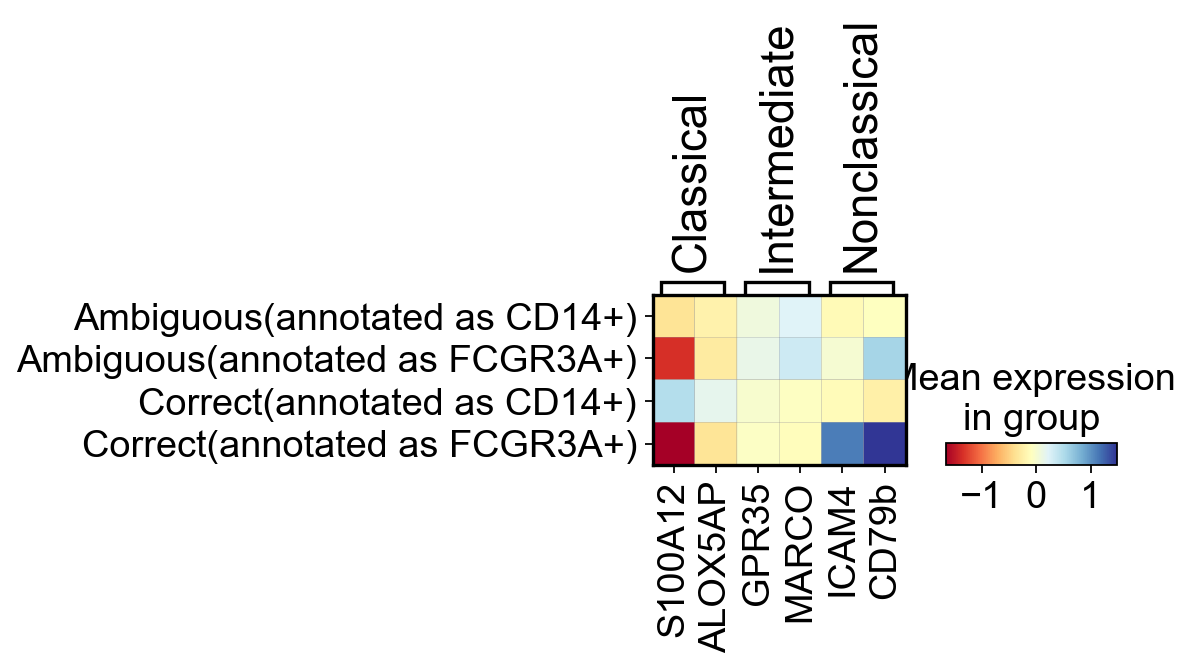

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.8) | (adata_cd14.obs['var'] < 0.1))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/2120759.py:69: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.8) | (adata_fc.obs['var'] < 0.1))


0.8 0.1


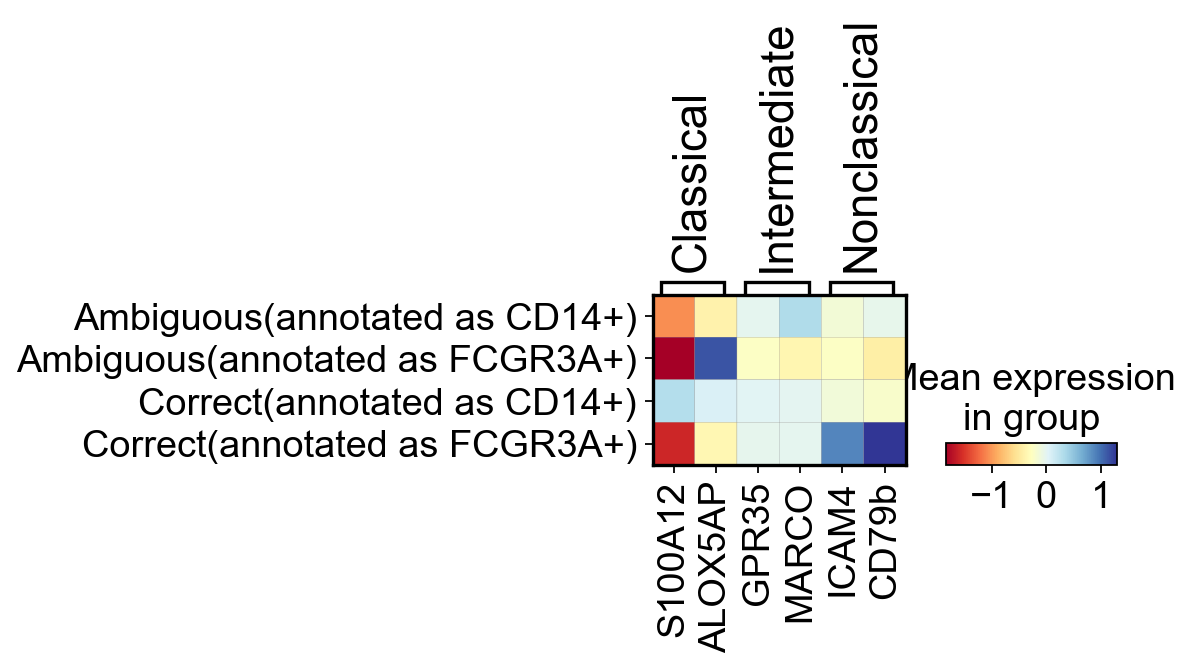

In [55]:
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.7) | (adata_cd14.obs['var'] < 0.1))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.7) | (adata_fc.obs['var'] < 0.1))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.7 0.1')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.1))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.95) | (adata_fc.obs['var'] < 0.1))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.95 0.1')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.8) | (adata_cd14.obs['var'] < 0.1))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.8) | (adata_fc.obs['var'] < 0.1))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.8 0.1')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


In [56]:
from scipy import stats
#adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
#adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
#adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
#adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
#adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
#adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

gene_list =['ENSG00000163221','ENSG00000132965','ENSG00000178623','ENSG00000019169','ENSG00000105371','ENSG00000007312']
names_list = ['S100A12','ALOX5AP','ENSG00000178623','ENSG00000019169','ENSG00000105371','ENSG00000007312']

#print(((adata_cd14[:,'ENSG00000163221'].X)))
for i, gene in enumerate(gene_list):
    #print((np.array(adata_cd14[:,gene].X).shape))
    #print(stats.spearmanr(np.array(adata_cd14[:,adata_cd14.var['alt_names'].isin([gene])].X[:,0]).ravel(),np.array(adata_cd14.obs['conf'])))
    print(names_list[i])
    print(stats.spearmanr(np.array(adata_cd14[:,gene].X.toarray()),np.array(adata_cd14.obs['var']) ))
    print(stats.spearmanr(np.array(adata_fc[:,gene].X.toarray()),np.array(adata_fc.obs['var'])))
    #print(((adata_cd14[:,adata_cd14.var['alt_names'].isin([gene])].X[:,0])[:,0]).shape)
    #print(np.array(adata_cd14.obs['conf']).shape)
    #print((np.array(adata_cd14[:,adata_cd14.var['alt_names'].isin([gene])].X[:,0]).reshape(-1).shape))
    
    
    
    
    

S100A12
SpearmanrResult(correlation=-0.47733918660080715, pvalue=4.122552880317608e-127)
SpearmanrResult(correlation=0.16710009609083465, pvalue=0.001680453682089433)
ALOX5AP
SpearmanrResult(correlation=-0.19404009851496778, pvalue=2.4701394763958142e-20)
SpearmanrResult(correlation=0.11305997118176836, pvalue=0.0342245879893646)
ENSG00000178623
SpearmanrResult(correlation=0.03736696682330165, pvalue=0.07789813518987068)
SpearmanrResult(correlation=0.09886711334150437, pvalue=0.06428431754131926)
ENSG00000019169
SpearmanrResult(correlation=0.13719067020963358, pvalue=7.962598189002196e-11)
SpearmanrResult(correlation=0.23451805883904359, pvalue=8.991891955424878e-06)
ENSG00000105371
SpearmanrResult(correlation=0.01601316761518784, pvalue=0.45006709988790117)
SpearmanrResult(correlation=-0.3453130005494229, pvalue=2.88971546687125e-11)
ENSG00000007312
SpearmanrResult(correlation=0.08552394127821353, pvalue=5.319911105916709e-05)
SpearmanrResult(correlation=-0.26774509405746, pvalue=3.55

conf 0.9 var 0.1

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3578599766.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.1))


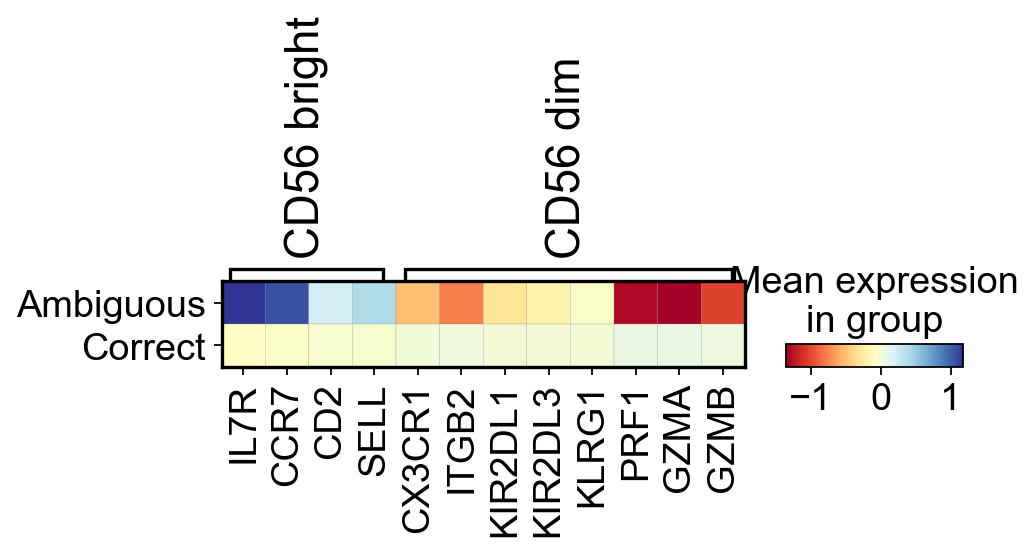

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3578599766.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.15))


conf 0.9 var 0.15


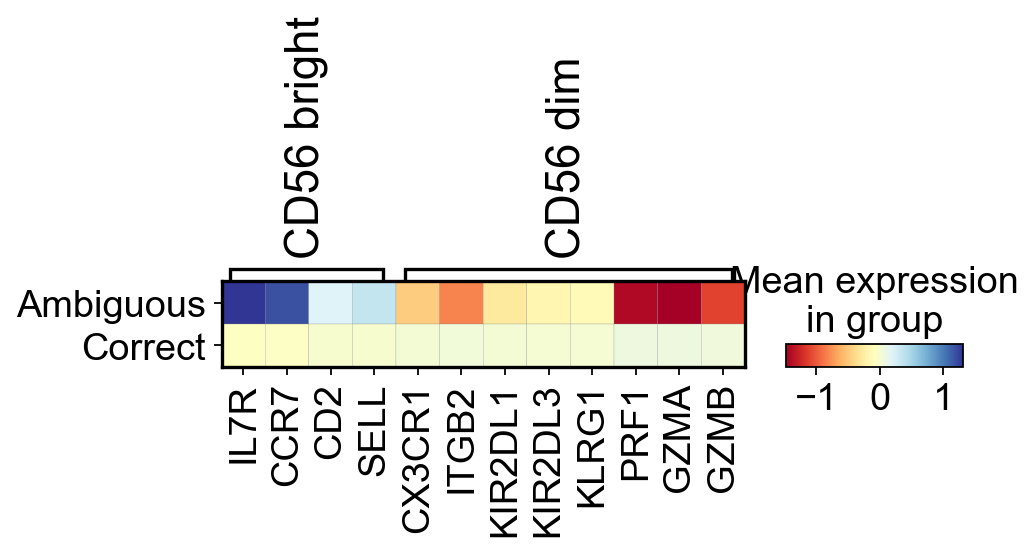

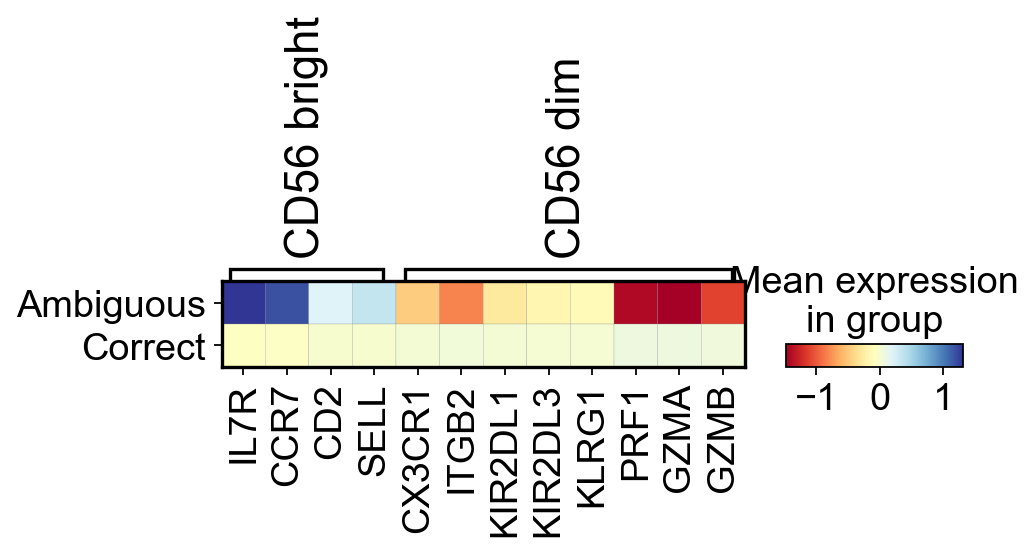

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3578599766.py:49: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.2))


conf 0.9 var 0.2


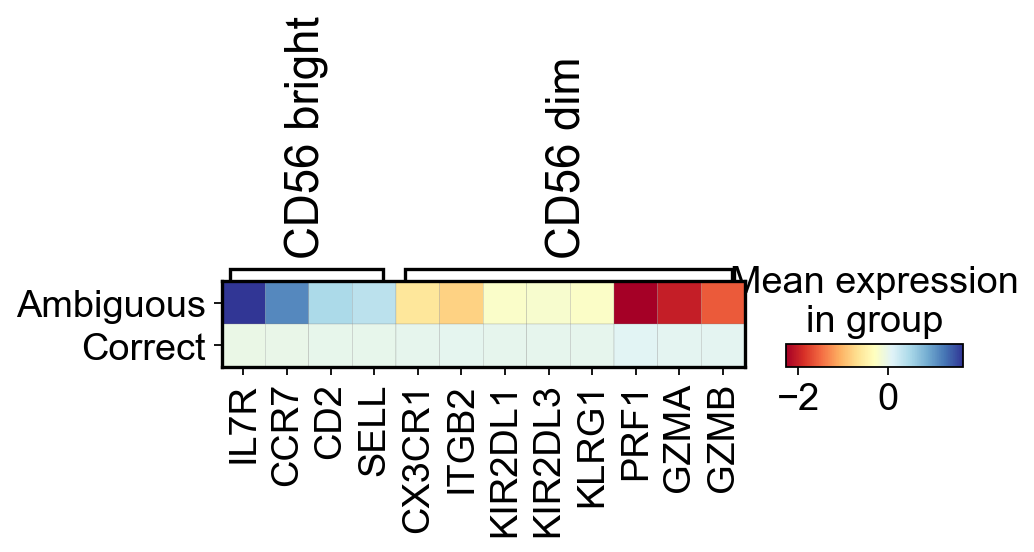

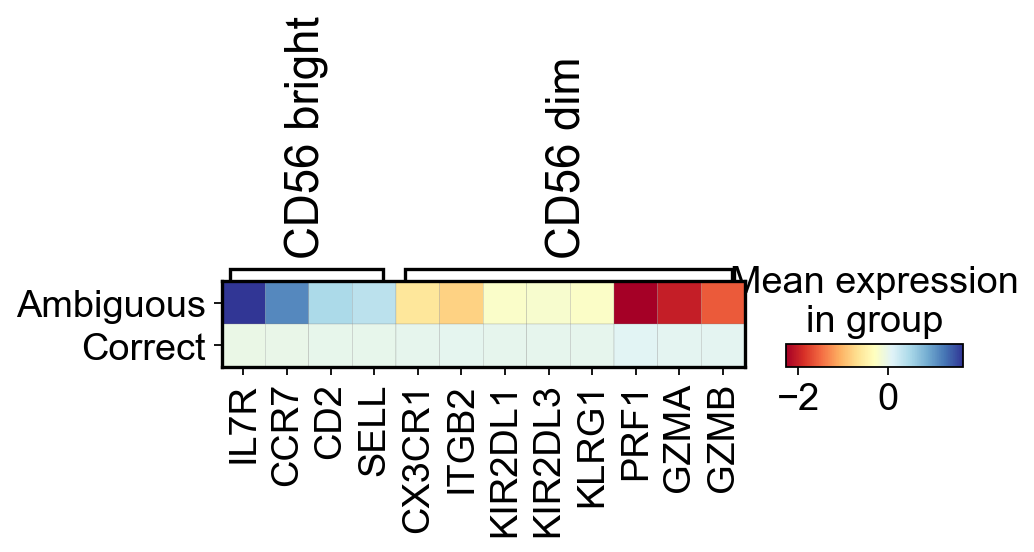

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/3578599766.py:73: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.97) | (adata_nk.obs['var'] < 0.1))


conf 0.97 var 0.1


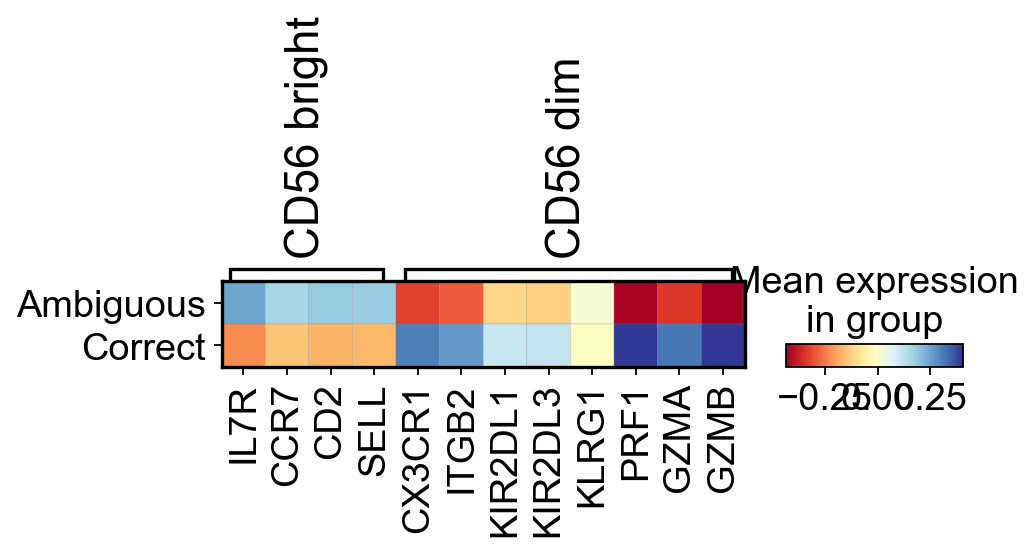

conf 0.97 var 0.15


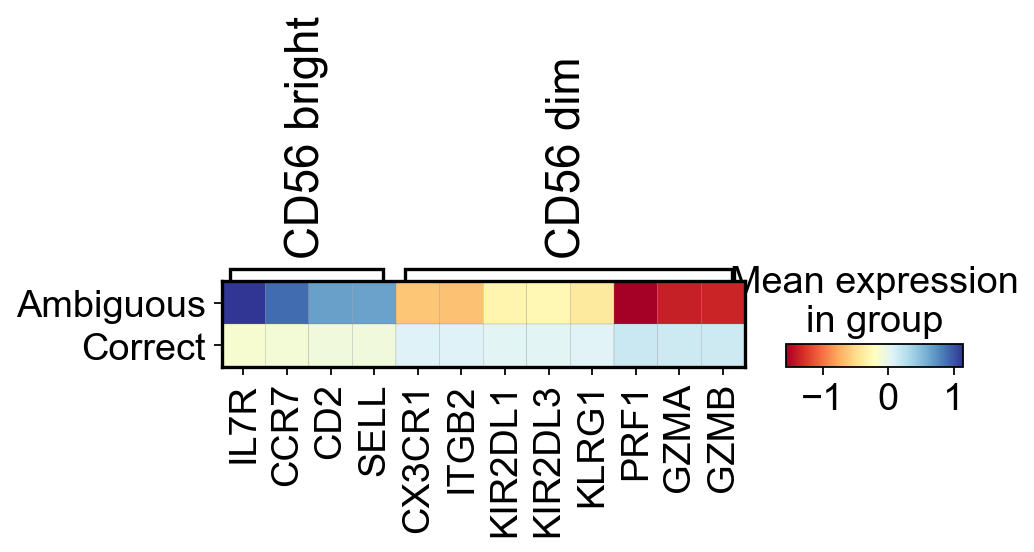

conf 0.97 var 0.2


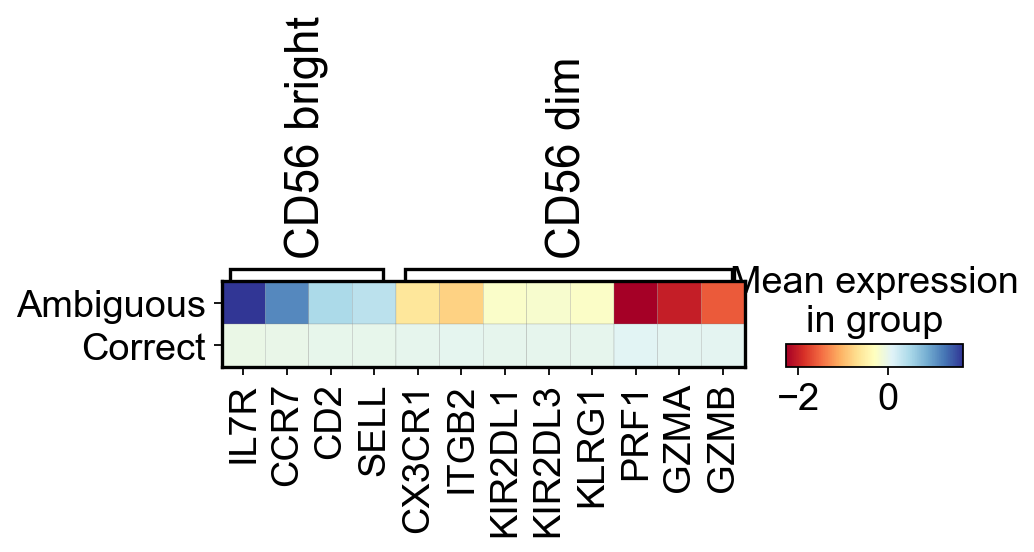

In [57]:
adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.1))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.9 var 0.1')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')

adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.9 var 0.15')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')

ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')

adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.9) | (adata_nk.obs['var'] < 0.2))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.9 var 0.2')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')


ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')

adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.97) | (adata_nk.obs['var'] < 0.1))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.97 var 0.1')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.97) | (adata_nk.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.97 var 0.15')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')

adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.97) | (adata_nk.obs['var'] < 0.2))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct')
    else: 
        corr_classified_list.append('Ambiguous')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
sc.pp.scale(adata_nk_sacled)
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
print('conf 0.97 var 0.2')
ax = sc.pl.matrixplot(adata_nk_sacled, cd56_genes_dict, groupby='amb_annotation',cmap='RdYlBu', gene_symbols='alt_names')


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.1))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.1))


0.9 0.1


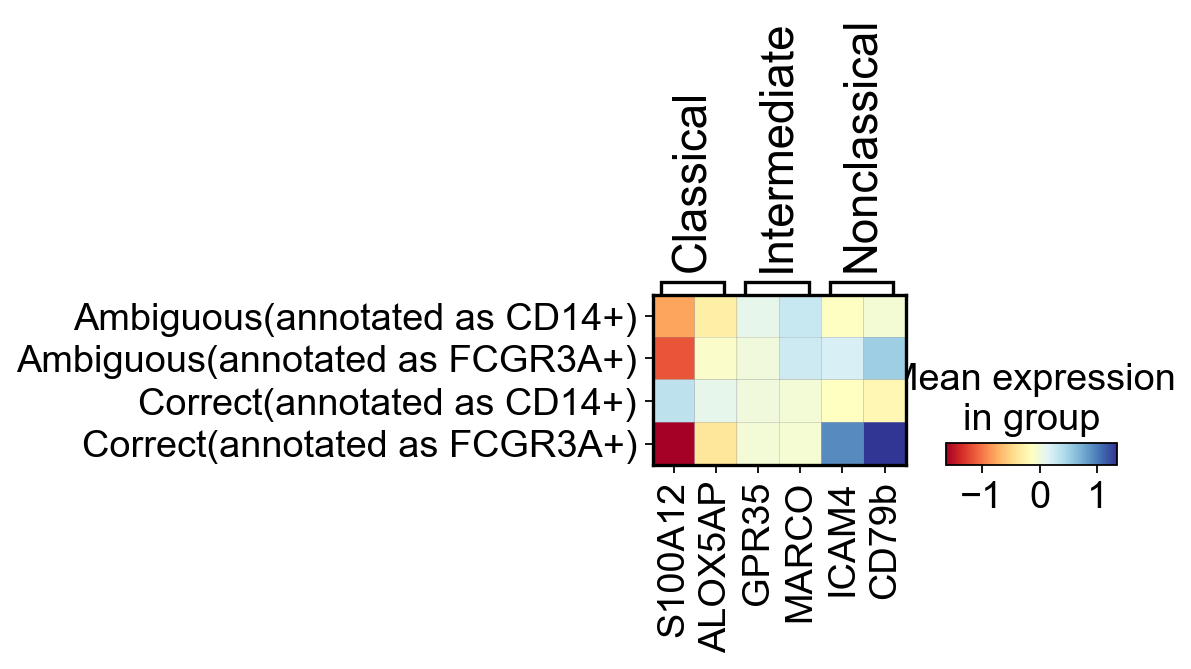

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:36: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.15))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:37: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.15))


0.9 0.15


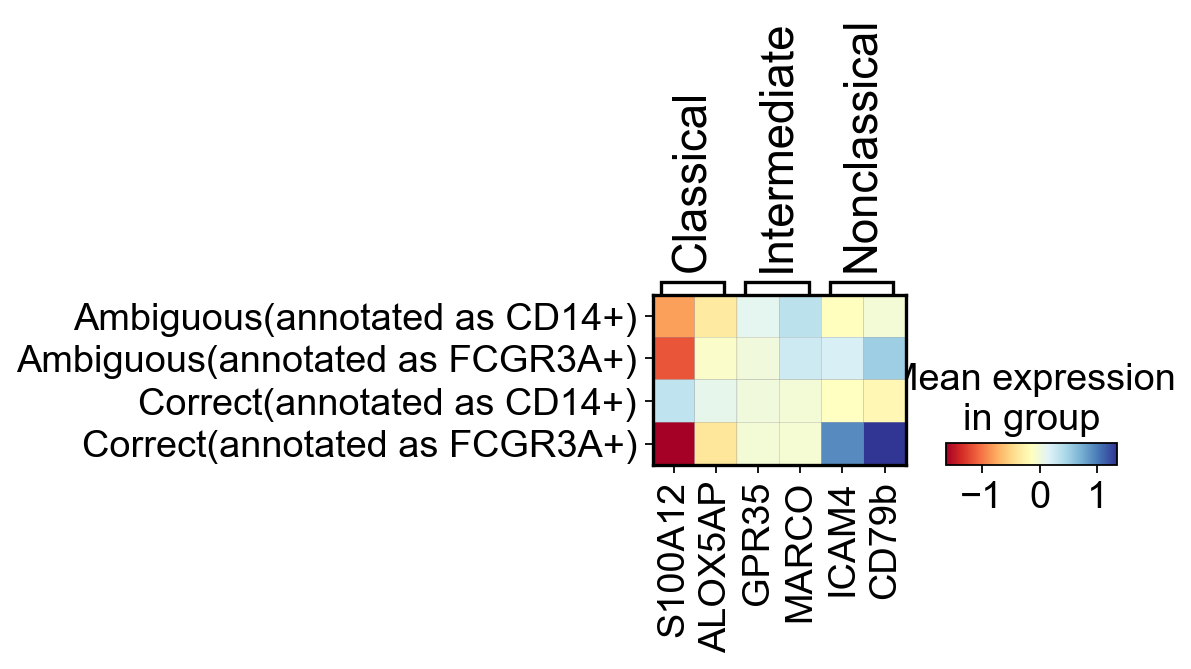

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.2))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:69: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.2))


0.9 0.2


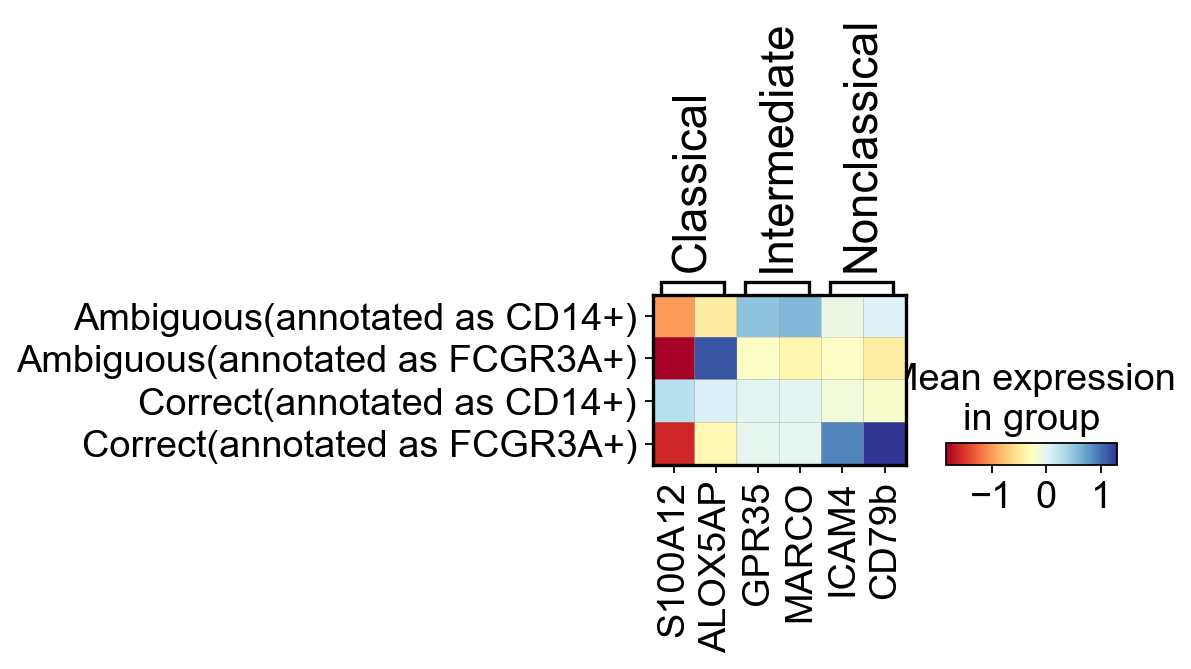

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:101: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.1))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:102: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.1))


0.97 0.1


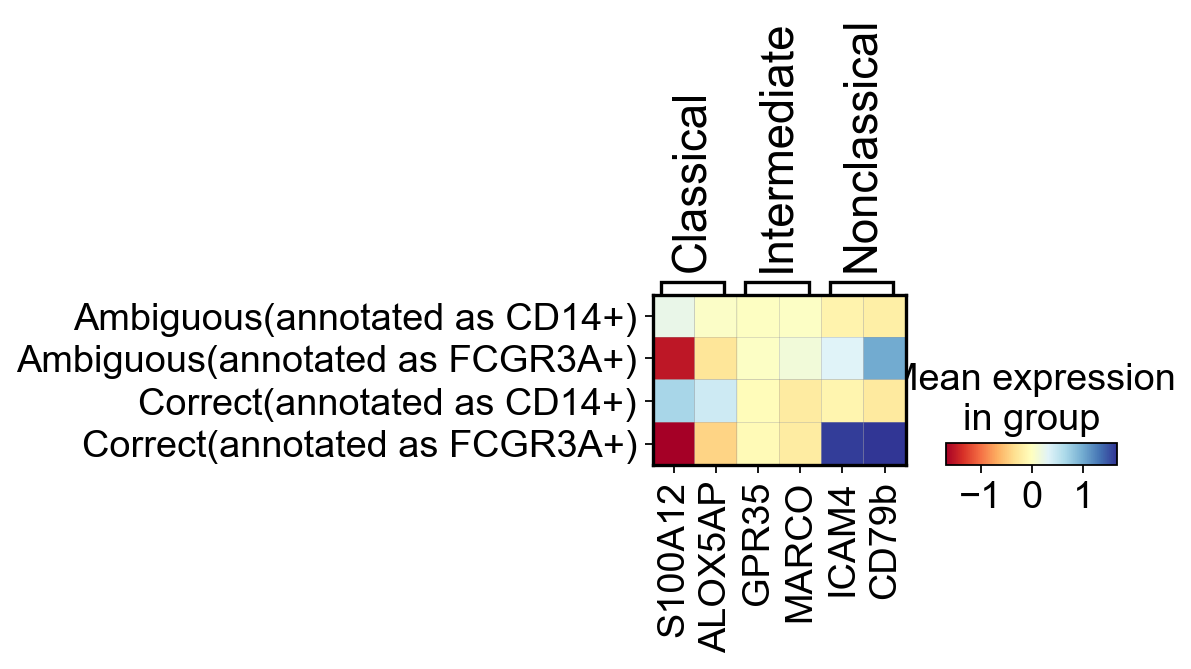

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:133: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.15))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:134: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.15))


0.97 0.15


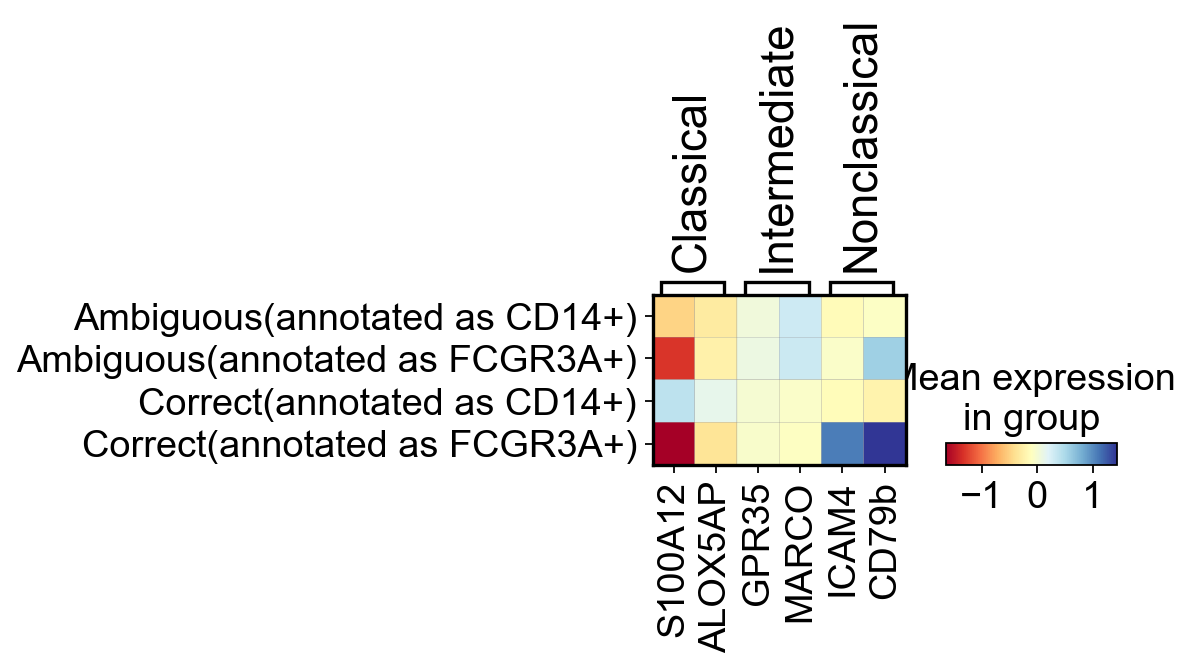

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.2))
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_38741/36654121.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.2))


0.97 0.2


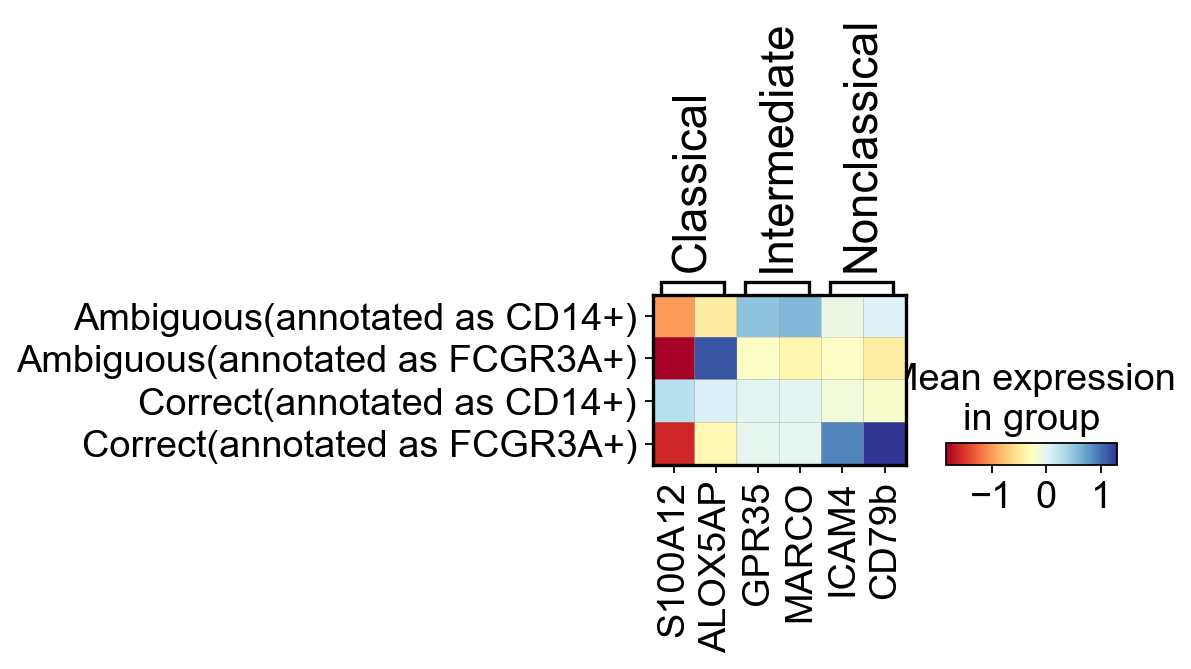

In [58]:
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.1))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.1))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.9 0.1')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.15))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.15))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.9 0.15')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.9) | (adata_cd14.obs['var'] < 0.2))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.9) | (adata_fc.obs['var'] < 0.2))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.9 0.2')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.1))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.1))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.97 0.1')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.15))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.15))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.97 0.15')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')

adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.97) | (adata_cd14.obs['var'] < 0.2))
adata_fc.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc.obs['conf'] > 0.97) | (adata_fc.obs['var'] < 0.2))

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correct(annotated as CD14+)')
    else:
        annotation_list_cd14.append('Ambiguous(annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correct(annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Ambiguous(annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }
print('0.97 0.2')
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


In [63]:
orig_adata = adata.copy()
for col in adata.obs.columns:
    if adata.obs[col].dtype != 'object':
        adata.obs[col] = adata.obs[col].astype(str)

# Now you can write the AnnData object to disk


In [64]:
adata_name = 'fig_2_adata.h5ad'
adata.write(adata_name)


In [75]:
import numba, seaborn, matplotlib, sklearn
print("numba " + str(numba.__version__))
print("seaborn " + str(seaborn.__version__))
print("matplotlib " + str(matplotlib.__version__))
print("sklearn " + str(sklearn.__version__))


numba 0.55.2
seaborn 0.11.2
matplotlib 3.5.1
sklearn 1.5.1


In [69]:
import scanpy
print(scanpy.__version__)


1.9.1
